# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, Facundo

**Información meteorológica**: Maximiliano Yafusco

## Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, balanced_accuracy_score, classification_report, confusion_matrix)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
#from scipy.stats import mode
import plotly.graph_objs as go
import plotly.express as px
import optuna
import jinja2
import pycaret
from pycaret.classification import *
import tensorflow as tf
import shap
import joblib
import json
import pickle
import sys
#!pip install nbconvert
from nbconvert import PythonExporter
import nbformat
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Especifica el archivo de entrada (notebook) y salida (script Python)
notebook_filename = 'TP_clasificacion_AA1_marce.ipynb'
script_filename = 'clasificación.py'


# Crear un exportador Python
python_exporter = PythonExporter()

# Leer el archivo notebook utilizando nbformat para obtener el objeto NotebookNode
with open(notebook_filename, 'r', encoding='utf-8') as notebook_file:
    notebook_content = nbformat.read(notebook_file, as_version=4)  # Cargar como NotebookNode

# Convertir el notebook a un script Python
script, _ = python_exporter.from_notebook_node(notebook_content)

# Guardar el script convertido en un archivo Python
with open(script_filename, 'w', encoding='utf-8') as script_file:
    script_file.write(script)

print(f"El notebook ha sido exportado a {script_filename}")


El notebook ha sido exportado a clasificación.py


## 1. Análisis descriptivo 

### Observación del Dataset.

In [309]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [310]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

El dataset corresponde a los datos meteorológicos de Australia.

En el norte del país el clima es tropical, en el este y oeste el clima es mediterráneo y en el centro es desértico.

Por este motivo y dado a que la selección de las 10 ciudades es aleatoria, decidimos conservar la información de la variable Location, a través de sus coordenadas (Latitude, Longitude), lo que además generaliza el modelo a otras ubicaciones.

Dartmoor, Victoria: Latitud: -37.9167 Longitud: 141.2833

Nuriootpa, South Australia: Latitud: -34.4700 Longitud: 138.9960

Perth Airport, Western Australia: Latitud: -31.9403 Longitud: 115.9668

Uluru, Northern Territory: Latitud: -25.3444 Longitud: 131.0369

Cobar, New South Wales: Latitud: -31.4983 Longitud: 145.8389

Coffs Harbour, New South Wales: Latitud: -30.2963 Longitud: 153.1157

Walpole, Western Australia: Latitud: -34.9780 Longitud: 116.7330

Cairns, Queensland: Latitud: -16.9203 Longitud: 145.7700

Alice Springs, Northern Territory: Latitud: -23.6980 Longitud: 133.8807

Gold Coast, Queensland: Latitud: -28.0167 Longitud: 153.4000

In [311]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]

In [312]:
ciudades_coords = {
    'Dartmoor': {'Latitud': -37.9167, 'Longitud': 141.2833},
    'Nuriootpa': {'Latitud': -34.4700, 'Longitud': 138.9960},
    'PerthAirport': {'Latitud': -31.9403, 'Longitud': 115.9668},
    'Uluru': {'Latitud': -25.3444, 'Longitud': 131.0369},
    'Cobar': {'Latitud': -31.4983, 'Longitud': 145.8389},
    'CoffsHarbour': {'Latitud': -30.2963, 'Longitud': 153.1157},
    'Walpole': {'Latitud': -34.9780, 'Longitud': 116.7330},
    'Cairns': {'Latitud': -16.9203, 'Longitud': 145.7700},
    'AliceSprings': {'Latitud': -23.6980, 'Longitud': 133.8807},
    'GoldCoast': {'Latitud': -28.0167, 'Longitud': 153.4000}
}

df_weather['Latitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Latitud'])
df_weather['Longitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Longitud'])
df_weather = df_weather.drop('Location',axis=1)

In [313]:
df_weather.shape

(28749, 24)

In [314]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [315]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [316]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
# df_weather['Date'] = pd.to_datetime(df_weather['Date'], errors='coerce')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)


In [317]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28234 entries, 6049 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28234 non-null  datetime64[ns]
 1   MinTemp        28193 non-null  float64       
 2   MaxTemp        28211 non-null  float64       
 3   Rainfall       28049 non-null  float64       
 4   Evaporation    18330 non-null  float64       
 5   Sunshine       15473 non-null  float64       
 6   WindGustDir    27545 non-null  object        
 7   WindGustSpeed  27591 non-null  float64       
 8   WindDir9am     26591 non-null  object        
 9   WindDir3pm     27770 non-null  object        
 10  WindSpeed9am   27878 non-null  float64       
 11  WindSpeed3pm   27886 non-null  float64       
 12  Humidity9am    27887 non-null  float64       
 13  Humidity3pm    27881 non-null  float64       
 14  Pressure9am    27926 non-null  float64       
 15  Pressure3pm    27926

In [318]:
df_weather.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
6049 2009-01-01     17.9     35.2       0.0         12.0      12.3   
6050 2009-01-02     18.4     28.9       0.0         14.8      13.0   
6051 2009-01-03     15.5     34.1       0.0         12.6      13.3   
6052 2009-01-04     19.4     37.6       0.0         10.8      10.6   
6053 2009-01-05     21.9     38.4       0.0         11.4      12.2   

     WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  \
6049         SSW           48.0        ENE         SW  ...       1004.4   
6050           S           37.0        SSE        SSE  ...       1012.1   
6051          SE           30.0        NaN          N  ...       1011.6   
6052         NNE           46.0        NNE        NNW  ...       1009.2   
6053         WNW           31.0        WNW        WSW  ...       1009.1   

      Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Latitude  \
6049       2.0       5.0     26.6     33.4         No            No  -31.4983   
6050       1.0       1.0     20.3     27.0         No            No  -31.4983   
6051       NaN       1.0      NaN     32.7         No            No  -31.4983   
6052       1.0       6.0     28.7     34.9         No            No  -31.4983   
6053       1.0       5.0     29.1     35.6         No            No  -31.4983   

      Longitude  Month  
6049   145.8389    ene  
6050   145.8389    ene  
6051   145.8389    ene  
6052   145.8389    ene  
6053   145.8389    ene  

[5 rows x 25 columns]

### División del DataSet: Train - Test

In [319]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 24), (5647, 24), (22587,), (5647,))

In [320]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [321]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [322]:
X_train.shape

(22253, 24)

In [323]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

Date  MinTemp  MaxTemp  Rainfall  Evaporation  \
count                          22253  22228.0  22236.0   22159.0      14656.0   
mean   2013-05-01 00:43:13.591875072     13.6     25.0       2.6          5.8   
min              2008-12-01 00:00:00     -5.2      7.0       0.0          0.0   
25%              2011-02-13 00:00:00      8.8     19.8       0.0          2.8   
50%              2013-06-26 00:00:00     13.4     24.9       0.0          5.0   
75%              2015-07-04 00:00:00     18.8     29.9       0.8          8.0   
max              2017-06-25 00:00:00     31.0     46.6     371.0         86.2   
std                              NaN      6.4      6.9      10.3          4.3   

       Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
count   12411.0        22032.0       22223.0       22223.0      22014.0   
mean        8.0           40.1          15.3          19.5         63.6   
min         0.0            9.0           0.0           0.0          1.0   
25%         5.3           31.0           9.0          13.0         50.0   
50%         9.0           39.0          15.0          19.0         65.0   
75%        10.9           46.0          20.0          24.0         80.0   
max        14.3          113.0          72.0          61.0        100.0   
std         3.7           11.9           8.2           8.2         22.1   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
count      22009.0      22208.0      22208.0   13224.0   12828.0  22246.0   
mean          49.4       1017.5       1014.9       3.9       4.0     19.1   
min            1.0        982.0        985.1       0.0       0.0     -0.3   
25%           30.0       1013.0       1010.3       1.0       1.0     13.9   
50%           52.0       1017.4       1014.8       4.0       4.0     19.0   
75%           66.0       1021.9       1019.3       7.0       7.0     24.2   
max          100.0       1040.4       1037.7       8.0       8.0     39.4   
std           23.1          6.6          6.6       2.9       2.8      6.6   

       Temp3pm  Latitude  Longitude  
count  22241.0   22253.0    22253.0  
mean      23.5     -29.7      137.9  
min        5.3     -37.9      116.0  
25%       18.4     -34.5      131.0  
50%       23.2     -31.5      141.3  
75%       28.1     -25.3      145.8  
max       45.2     -16.9      153.4  
std        6.8       6.0       12.8

In [324]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         41.0
Evaporation      34.0
WindDir9am        5.0
Humidity3pm       1.0
Humidity9am       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
RainToday         0.0
Rainfall          0.0
Pressure9am       0.0
Pressure3pm       0.0
WindSpeed3pm      0.0
WindSpeed9am      0.0
MinTemp           0.0
MaxTemp           0.0
Temp3pm           0.0
Temp9am           0.0
Longitude         0.0
Date              0.0
Latitude          0.0
Month             0.0
dtype: float64

In [325]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Latitude
Longitude
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [326]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

In [327]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         18.18
WindGustSpeed     2.64
Evaporation       1.88
WindSpeed3pm      1.52
WindSpeed9am      1.12
Pressure9am       0.79
Pressure3pm       0.59
Humidity9am       0.10
Temp3pm           0.05
MaxTemp           0.01
MinTemp           0.00
Temp9am           0.00
Latitude          0.00
Humidity3pm       0.00
Cloud3pm          0.00
Cloud9am          0.00
Sunshine          0.00
Longitude         0.00
dtype: float64

### Visualización de datos: boxplots, histogramas y scatter plots

In [328]:
def visualizar_features_cuanti_sin_lluvia(tipo_grafico: str) -> None:
    # A la feature lluvia Rainfall se le aplicará un análisis particular
    features_cuanti_sin_lluvia = features_cuanti.copy()
    features_cuanti_sin_lluvia.remove('Rainfall')
    n_features_cuanti_sin_lluvia = len(features_cuanti_sin_lluvia)
    n_col = 3
    n_row = n_features_cuanti_sin_lluvia // n_col if n_features_cuanti_sin_lluvia % n_col == 0 else n_features_cuanti_sin_lluvia // n_col + 1
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col * 5, 5 * n_row))
    titulo = 'Boxplots de las variables predictoras cuantitativas según valor de la variable target' if tipo_grafico == 'boxplots' else "Histogramas de variables cuantitativas"
    fig.suptitle(titulo, fontsize=16)
    fig.subplots_adjust(hspace=0.2)

    # Definir la paleta de colores para 'Yes' y 'No'
    palette = {'Yes': 'darkorange', 'No': 'lightblue'}

    for i, feature in enumerate(features_cuanti_sin_lluvia):
        # Posición de cada gráfico 
        row = i // n_col
        col = i % n_col
        
        if tipo_grafico == 'boxplots':
            sns.boxplot(data=X_train, x=y_train, y=feature, ax=axes[row, col], palette=palette)
        else:
            sns.histplot(df_train[feature],ax=axes[row, col])  
                # Eliminar subplots vacíos si es necesario
    if n_features_cuanti_sin_lluvia % n_col != 0:
        for i in range(n_features_cuanti_sin_lluvia % n_col, n_col):
            fig.delaxes(axes[n_row - 1, i])

    plt.show()


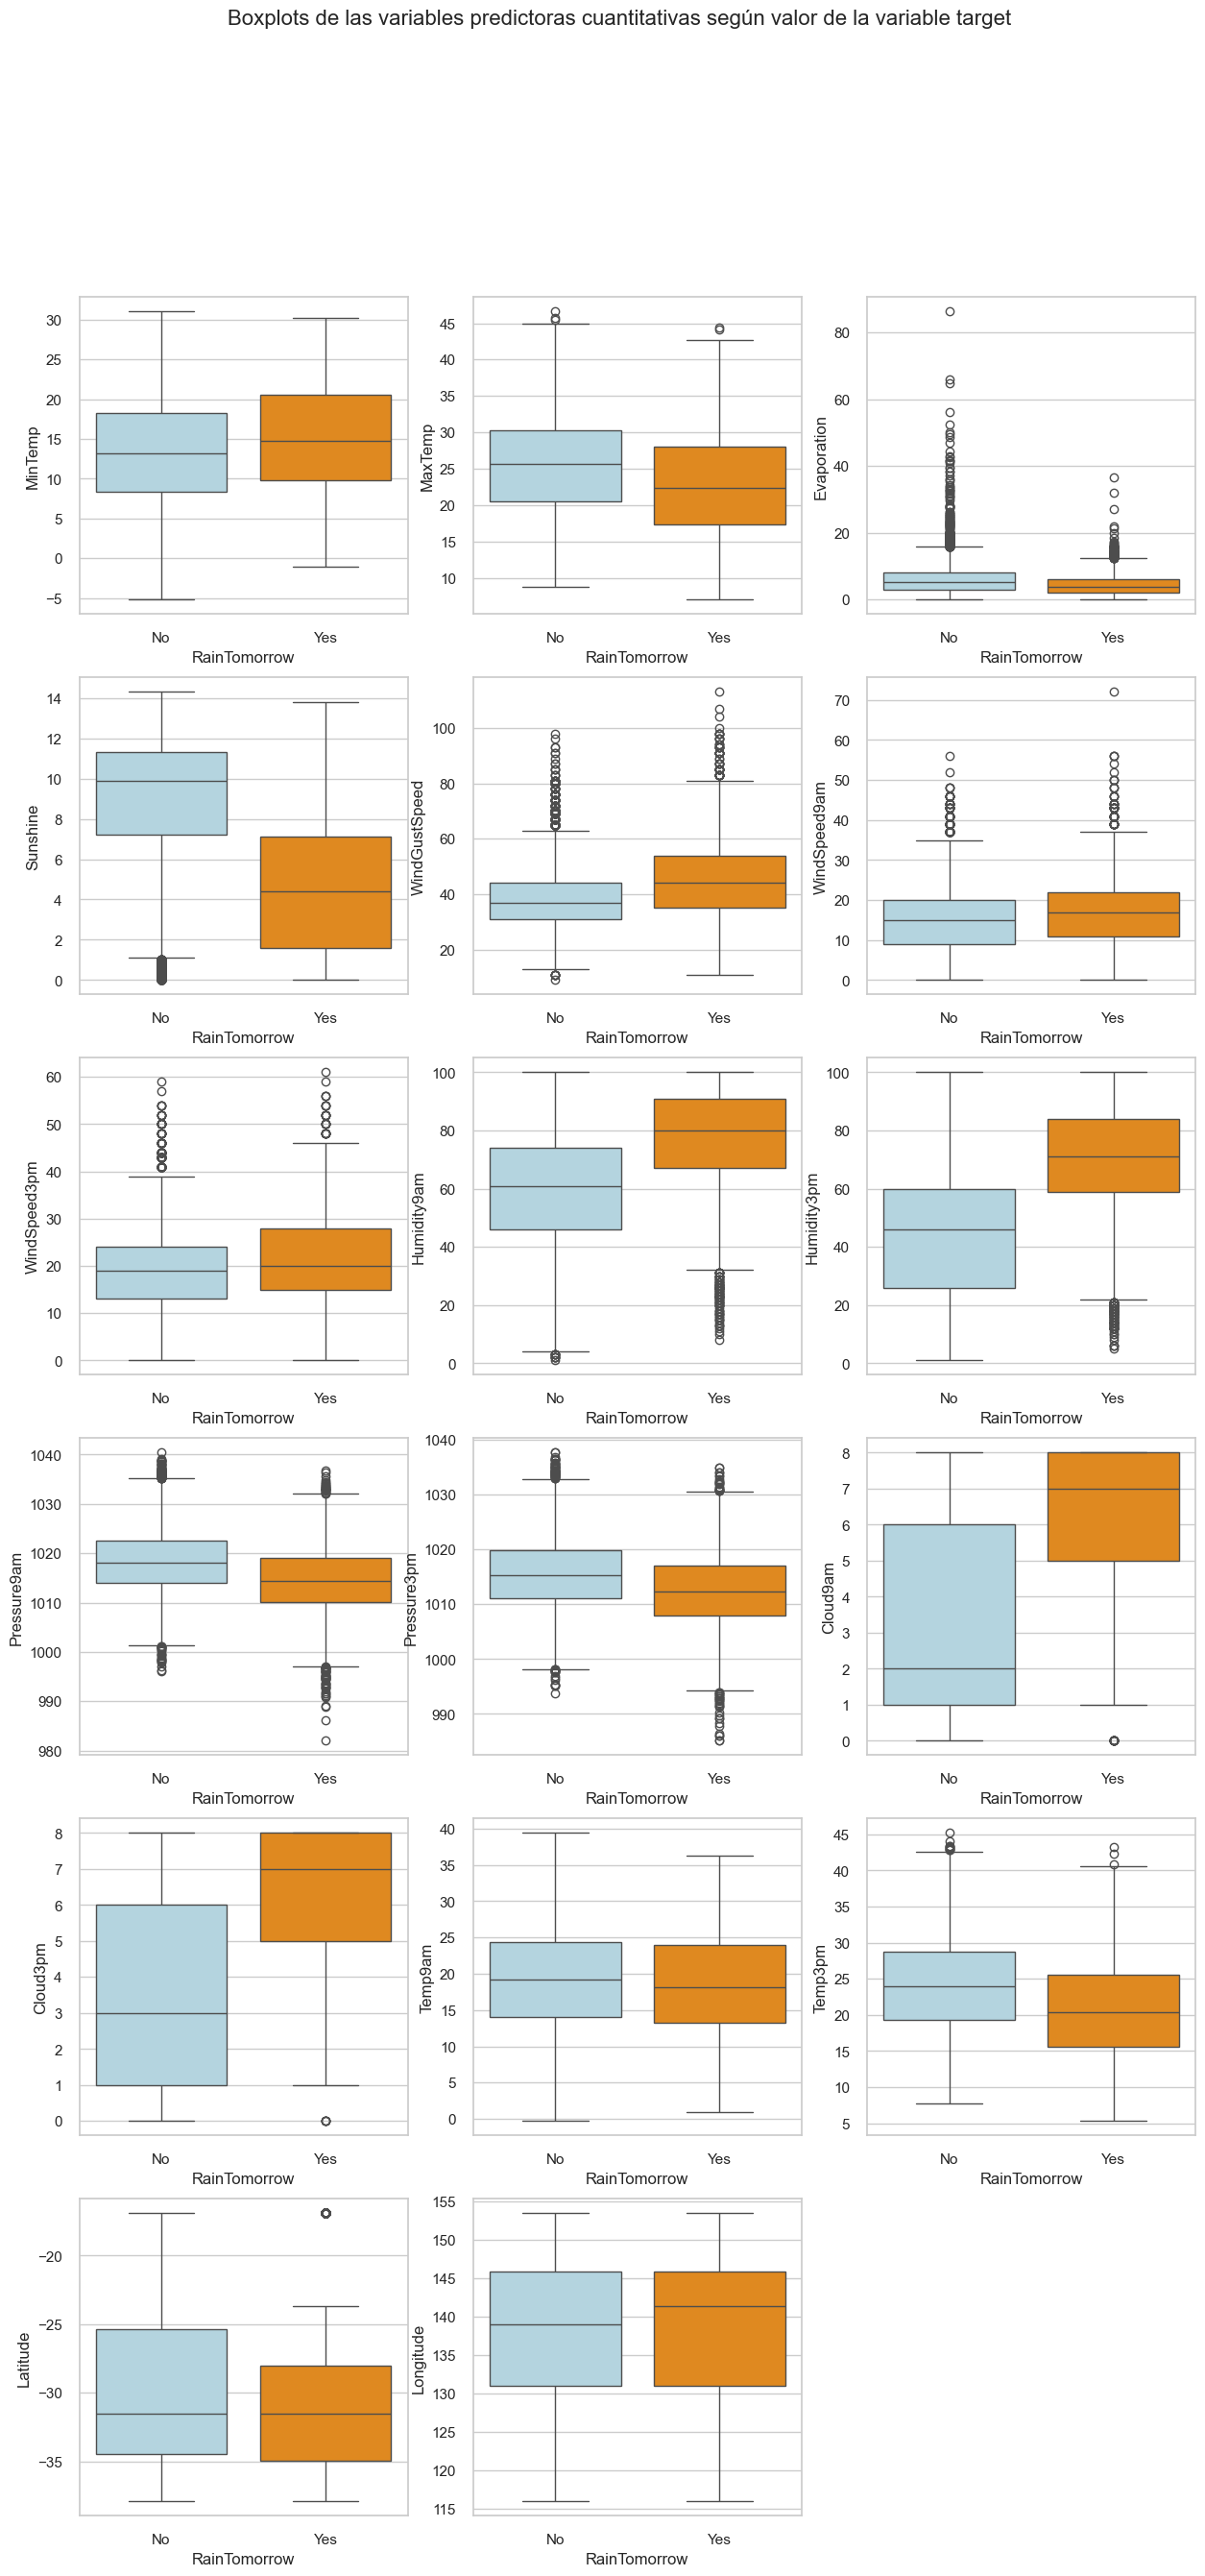

In [329]:
# A la función puede recibir el string boxplots, caso contrario grafica histogramas
visualizar_features_cuanti_sin_lluvia('boxplots')

Se observa que cuando la humedad es mayor al 60% es altamente probable que llueva.

Cuando no llovió, solamente en el 25% de los casos la humedad presentó un valor mayor.

Cuando sí llovió, en el 75% de los casos, el valor superó dicha referencia. 

Esto se informa a modo de justificación acerca de la elección de esta variable para construir el modelo ingenuo solicitado en el punto 3 del TP.

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (Sunshine | Cloud9am | Cloud3pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad.

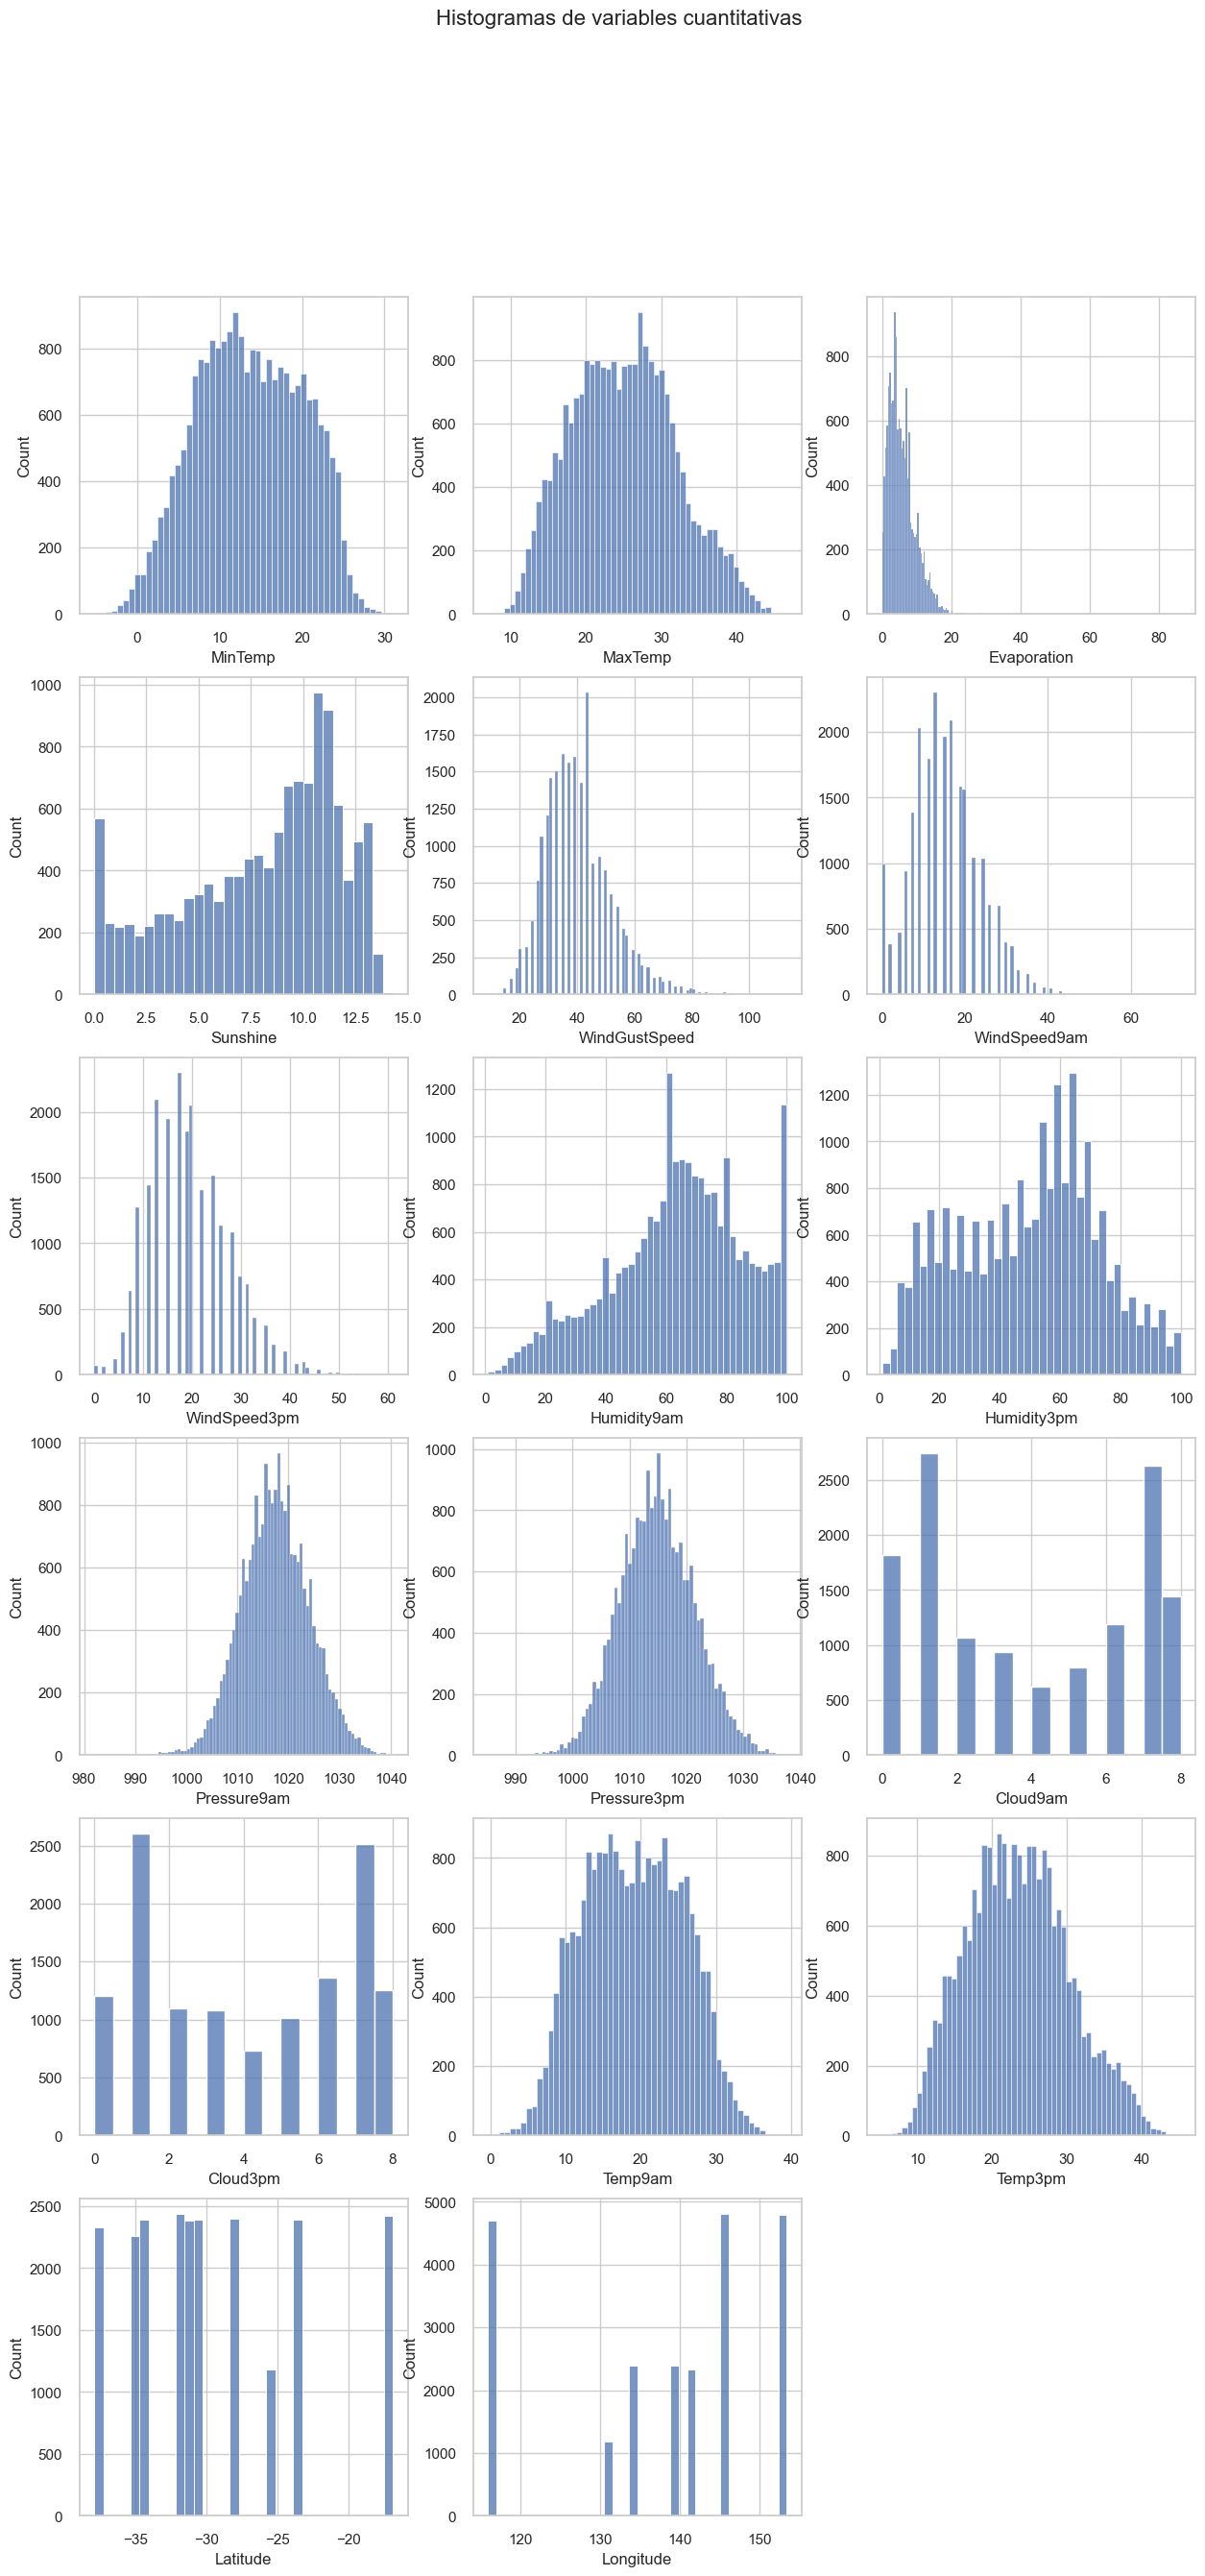

In [330]:
visualizar_features_cuanti_sin_lluvia('histogramas')

El análisis de los histogramas serán tenidos en cuenta para la imputación de faltantes.
Se observa que las siguientes features son 
* simétricas:
Temperatura (en todas sus versiones)
* asimétricas:
Evaporación | Viento (en todas sus versiones) | Humedad (en todas sus versiones) | Presión (en todas sus versiones)
* bimodales:
Nubosidad (en todas sus versiones) | Radiación Solar

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

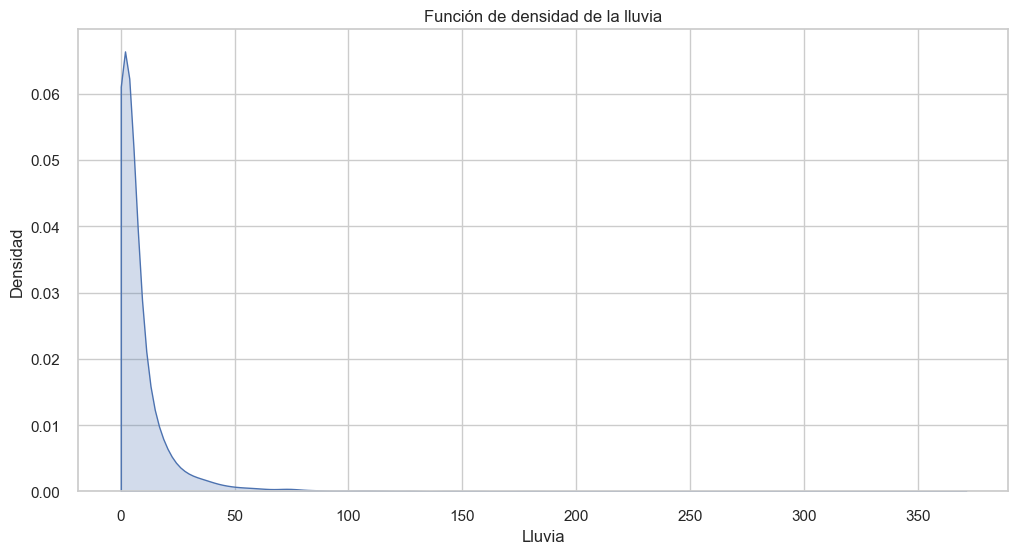

In [331]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [332]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),4)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

Frecuencia_absoluta  Frecuencia_relativa  \
Rainfall                                               
(0, 50]                    7467               0.9780   
(50, 100]                   119               0.0156   
(100, 150]                   32               0.0042   
(150, 200]                   11               0.0014   
(200, 250]                    3               0.0004   
(250, 300]                    2               0.0003   
(300, 350]                    0               0.0000   
(350, 400]                    1               0.0001   

            Frecuencia_absoluta_acumulada  Frecuencia_relativa_acumulada  
Rainfall                                                                  
(0, 50]                              7467                         0.9780  
(50, 100]                            7586                         0.9936  
(100, 150]                           7618                         0.9978  
(150, 200]                           7629                         0.9992  
(200, 250]                           7632                         0.9996  
(250, 300]                           7634                         0.9999  
(300, 350]                           7634                         0.9999  
(350, 400]                           7635                         1.0000

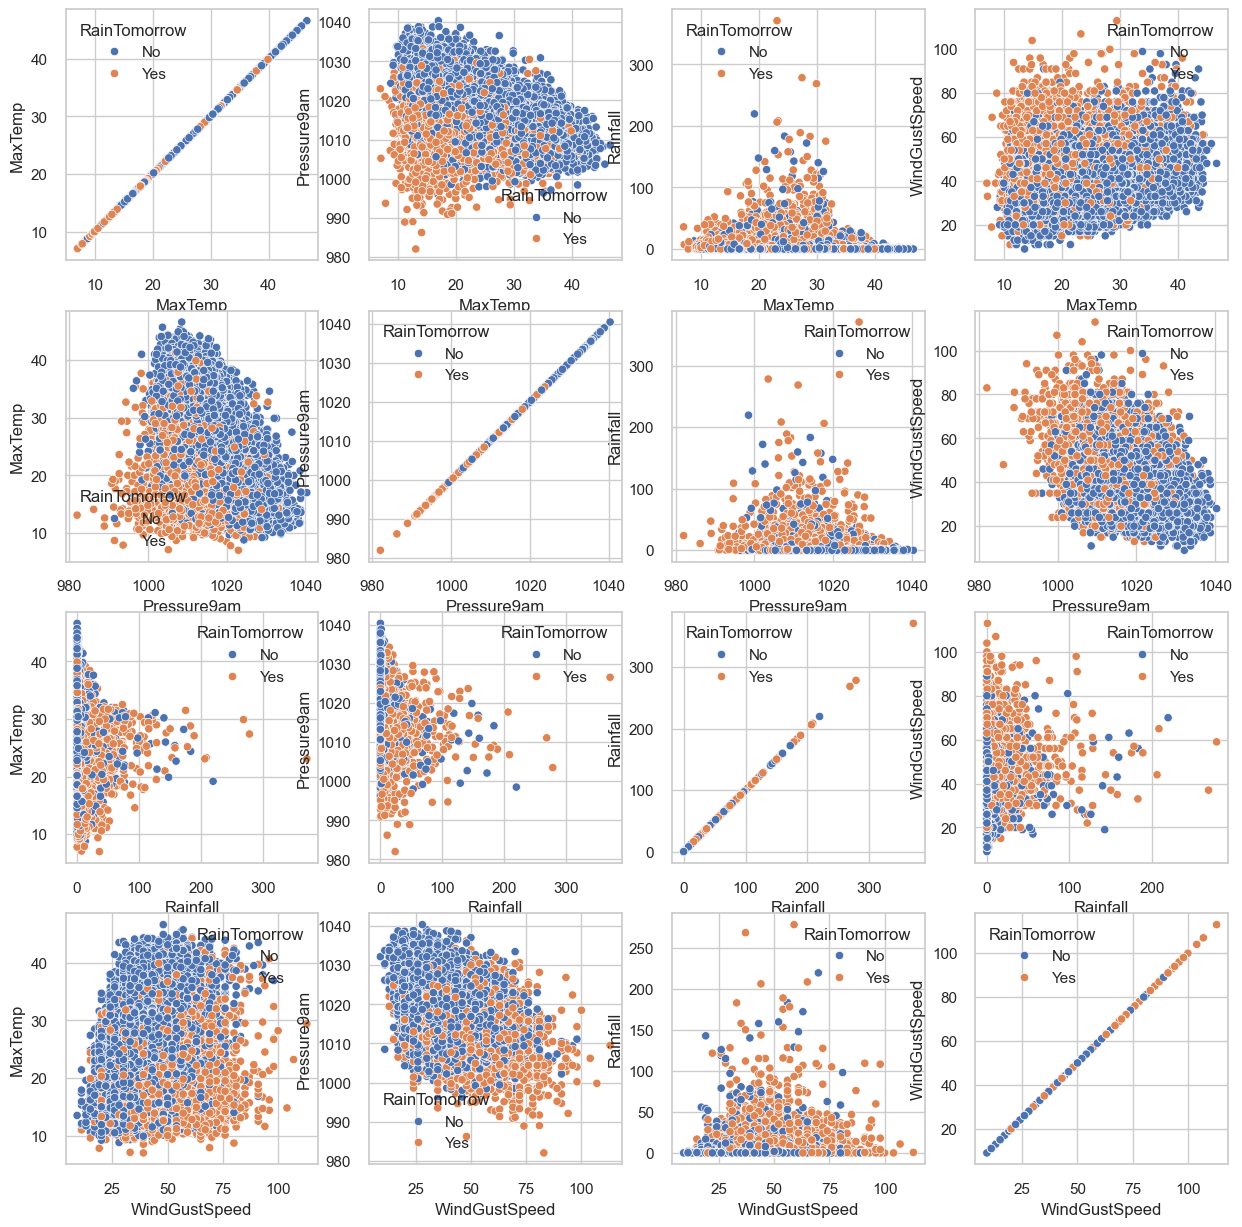

In [333]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
columns = ['MaxTemp','Pressure9am','Rainfall','WindGustSpeed']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

En cualquier ubicación geográfica, Las condiciones meteorológicas que determinan una mayor probabilidad de lluvias son:
* Baja Presión
* Alta Temperatura + Alta Humedad

A partir de los gráficos de dispersión, se observa la posibilidad de trazar fácilmente una recta frontera en las gráficas, por ejemplo, Pressure9am vs MaxTemp, WindGustSpeed vs Pressure9am y WindGustSpeed vs MaxTemp para determinar la pertenencia a una clase de la target.

Al contrario, la feature RainFall no sirve para poder trazar una recta frontera junto a otra feature.

In [334]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

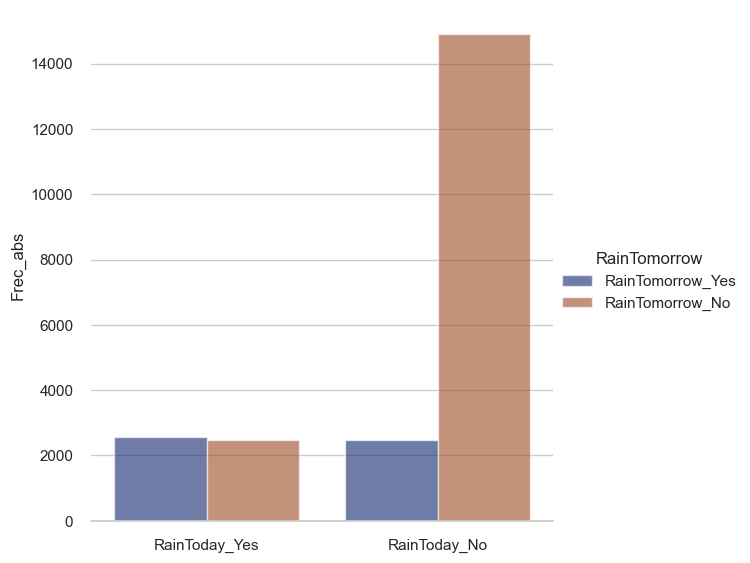

In [335]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

Se puede observar la correlación que existe entre RainToday y RainTomorrow:
* Si hoy llueve es más probable que mañana también llueva.
* Si hoy no llueve, es altamente probable que mañana no llueva.

### Matriz de correlación de variables

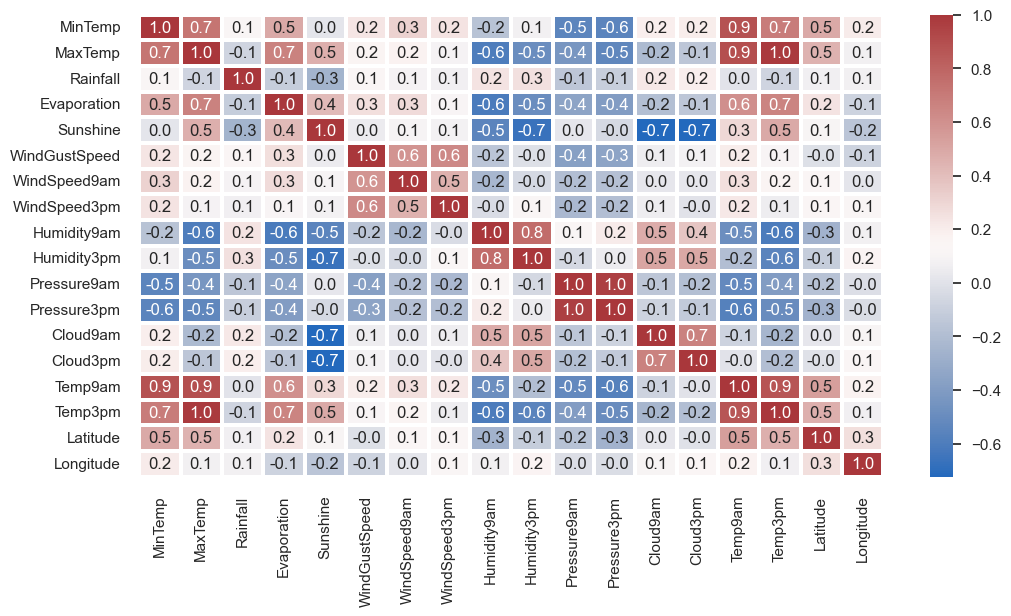

In [336]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un razgo entre las features.

Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas.

Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature Sunshine y las features vinculadas con la medición de la nubosidad.

### Análisis de balanceo del dataset 

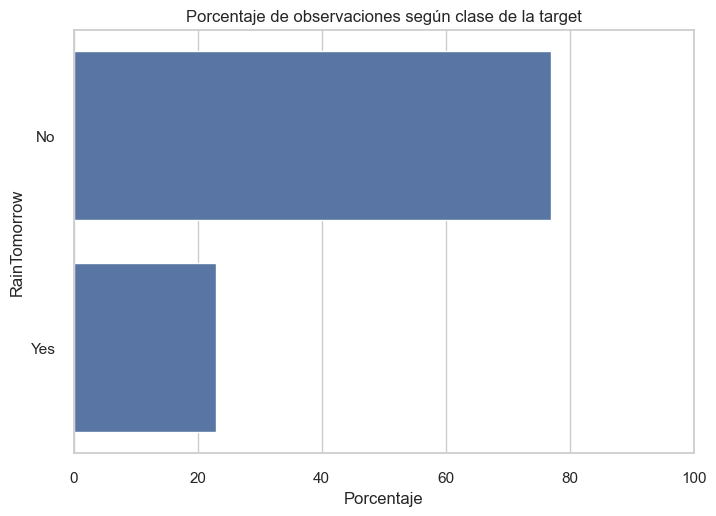

In [337]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

Clase RainTomorrow = no --> Clase negativa (mayoritaria)

Clase RainTomorrow = si --> Clase positiva (minoritaria)

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa. Es importante este análisis porque al estar desbalanceado corresponde aplicar las técnicas de oversampling, undersampling o discriminación de penalidad asignada a cada clase para evitar que modelo tienda a predecir la categoría mayoritaria.  

### Análisis y decisión sobre datos faltantes y atípicos

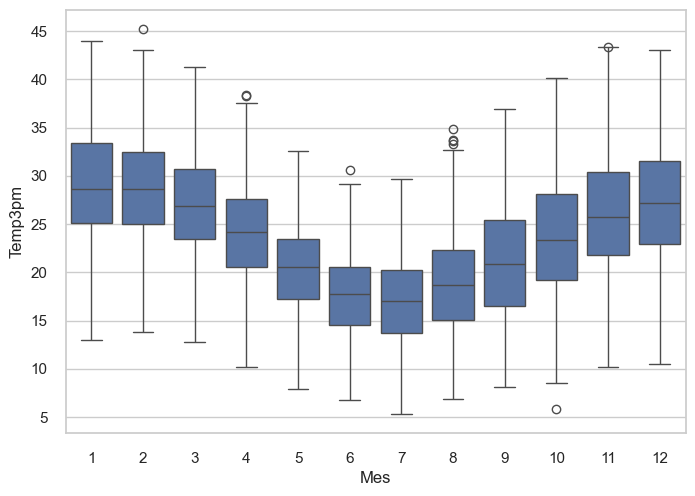

In [338]:
# Se analiza el caso de features que presentan un significativo comportamiento estacional
# y por ende puede que se justifique imputar faltantes aplicando un estadístico segmentado por mes
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

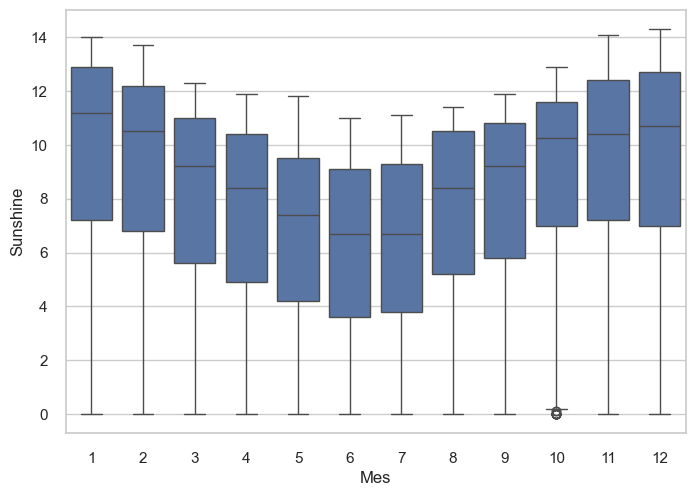

In [339]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

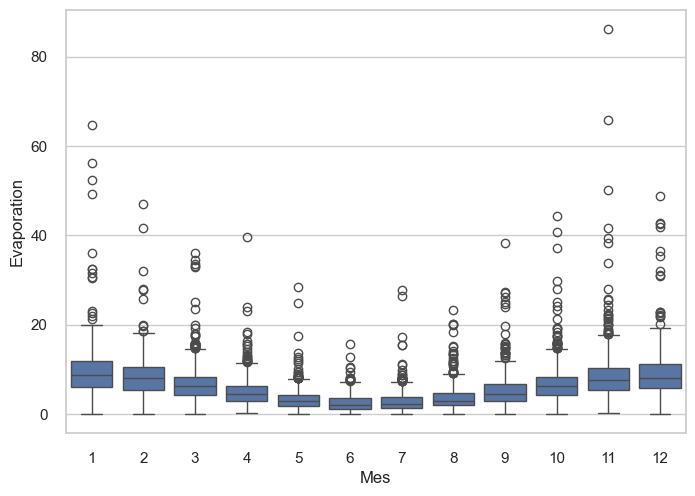

In [340]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

In [341]:
X_train.isna().sum()

Date                0
MinTemp            25
MaxTemp            17
Rainfall           94
Evaporation      7597
Sunshine         9842
WindGustDir       233
WindGustSpeed     221
WindDir9am       1020
WindDir3pm        100
WindSpeed9am       30
WindSpeed3pm       30
Humidity9am       239
Humidity3pm       244
Pressure9am        45
Pressure3pm        45
Cloud9am         9029
Cloud3pm         9425
Temp9am             7
Temp3pm            12
RainToday          94
Latitude            0
Longitude           0
Month               0
dtype: int64

Se decide el criterio para la imputación de las direcciones de vientos faltantes, basados en la consulta con un meteorólogo.

En la práctica, si falta la información de uno de los vientos, se completa el valor de alguno de los otros vientos del mismo día.
Esto no provoca fuga de datos porque es el procedimiento habitual en tiempo real.

Si faltan los valores de los 3 campos de direcciones de vientos, se imputan por la moda calculada en el conjunto de entrenamiento.

No se procede de igual manera para otras variables, por ejemplo, no se imputan los valores faltantes de la temperatura de las 9am con las de las 3pm debido al rango variación de sus valores. 

En estos casos, es preferible imputar por el promedio de los días próximos. En nuestro caso, imputamos por el promedio mensual o por la mediana, dependiendo del comportamiento de cada variable.

In [342]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
# que justifican imputar por media segmentada
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [343]:
# Función para imputar valores en las columnas de dirección del viento
def impute_wind_directions(row):
    if pd.notna(row['WindGustDir']):
        # Si WindGustDir no es nulo, imputar WindDir9am y WindDir3pm con ese valor
        if pd.isna(row['WindDir9am']):
            row['WindDir9am'] = row['WindGustDir']
        if pd.isna(row['WindDir3pm']):
            row['WindDir3pm'] = row['WindGustDir']
    else:
        # Si WindGustDir es nulo, imputar con los valores entre WindDir9am y WindDir3pm
        if pd.notna(row['WindDir9am']):
            row['WindGustDir'] = row['WindDir9am']
            if pd.isna(row['WindDir3pm']):
                row['WindDir3pm'] = row['WindDir9am']
        elif pd.notna(row['WindDir3pm']):
            row['WindGustDir'] = row['WindDir3pm']
            if pd.isna(row['WindDir9am']):
                row['WindDir9am'] = row['WindDir3pm']
    return row

# Aplicar la función a los DataFrames
X_train_imputed = X_train_imputed.apply(impute_wind_directions, axis=1)
X_test_imputed = X_test_imputed.apply(impute_wind_directions, axis=1)

In [344]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

In [345]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direction_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
for feature_cuali in features_cuali[:3]:
    X_train_imputed[feature_cuali] = X_train_imputed[feature_cuali].map(direction_dict)
    X_test_imputed[feature_cuali] = X_test_imputed[feature_cuali].map(direction_dict)
X_train_imputed.loc[0]

Date             2016-06-01 00:00:00
MinTemp                         11.9
MaxTemp                         23.2
Rainfall                         0.0
Evaporation                      2.6
Sunshine                    6.147587
WindGustDir                        E
WindGustSpeed                   30.0
WindDir9am                         E
WindDir3pm                         E
WindSpeed9am                     7.0
WindSpeed3pm                    19.0
Humidity9am                     77.0
Humidity3pm                     61.0
Pressure9am                   1020.9
Pressure3pm                   1018.4
Cloud9am                    4.303057
Cloud3pm                    4.351699
Temp9am                         17.4
Temp3pm                         22.4
RainToday                         No
Latitude                     -23.698
Longitude                   133.8807
Month                            jun
Name: 0, dtype: object

In [346]:
# Tratamiento de faltantes en features asimétricas que justican imputar por mediana simple
X_train_mediana_WindGustSpeed = X_train['WindGustSpeed'].median()
X_train_mediana_Humidity9am = X_train['Humidity9am'].median()
X_train_mediana_Humidity3pm = X_train['Humidity3pm'].median()
X_train_mediana_Rainfall = X_train['Rainfall'].median()
X_train_mediana_WindSpeed9am = X_train['WindSpeed9am'].median()
X_train_mediana_WindSpeed3pm = X_train['WindSpeed3pm'].median()
X_train_mediana_Pressure9am  = X_train['Pressure9am'].median()
X_train_mediana_Pressure3pm = X_train['Pressure3pm'].median()

X_train_imputed = X_train_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})

In [347]:
# Tratamiento de faltantes en features simétricas que justican imputar por media simple
X_train_mean_MinTemp = X_train['MinTemp'].mean()
X_train_mean_MaxTemp = X_train['MaxTemp'].mean()
X_train_mean_Temp9am = X_train['Temp9am'].mean()
X_train_mean_Temp3pm = X_train['Temp3pm'].mean()


X_train_imputed = X_train_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})

In [348]:
X_train_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [349]:
X_test_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

Tratamiento de valores atípicos para la feature Rainfall.

La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado para la variable en cuestión.

In [350]:
s_lluvia = X_train_imputed[X_train_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_imputed_idx_lluvia_ati = X_train_imputed[X_train_imputed['Rainfall']>valor_tipico_sup].index
X_train_imputed.loc[X_train_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_imputed[X_test_imputed['Rainfall']>valor_tipico_sup].index
X_test_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup

### Codificación de variables categóricas

In [351]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False,drop='first')
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [352]:
def codificar_target(serie:pd.Series):
    """Recibe una serie para cambiar el nombre y a su vez mapear 
    sus valores para codificarlos"""
    serie.name ='RainTomorrow_Yes'
    serie_codificada =  serie.map({"No":0,"Yes":1})
    return serie_codificada

In [353]:
# Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [354]:
X_train_encoded_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Latitude         0
Longitude        0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
RainToday_Yes    0
Month_ago        0
Month_dic        0
Month_ene        0
Month_feb        0
Month_jul        0
Month_jun        0
Month_mar        0
Month_may        0
Month_nov        0
Month_oct        0
Month_sep        0
dtype: int64

In [355]:
#Codificación de la target 
y_train_encoded = codificar_target(y_train)
y_test_encoded = codificar_target(y_test)
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [356]:
X_train_encoded_imputed.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')

In [357]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.147587           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.965803           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  Pressure3pm  \
0           30.0          E          E  ...       1020.9       1018.4   
1           41.0          S          W  ...       1025.8       1022.8   
2           41.0          N          W  ...       1010.9       1008.1   
3           33.0          E          S  ...       1017.4       1014.8   
4           39.0          E          S  ...       1018.2       1014.8   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  Latitude  L

### Escalado de datos 

In [358]:
# Escalado de datos - NO SE ESCALAN VARIABLES CUALITATIVAS
scaler = StandardScaler()
X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)


In [359]:
# Primero se filtra para eliminar las cuantitativas no escaladas para luego unir las cualitativas con las cuantitativas sí escaladas
X_train_encoded_imputed_cuali = X_train_encoded_imputed.drop(features_cuanti,axis=1)
X_train_encoded_imputed_cuantiscaled_cuali = pd.concat([X_train_encoded_imputed_scaled,X_train_encoded_imputed_cuali],axis=1)

X_test_encoded_imputed_cuali = X_test_encoded_imputed.drop(features_cuanti,axis=1)
X_test_encoded_imputed_cuantiscaled_cuali = pd.concat([X_test_encoded_imputed_scaled,X_test_encoded_imputed_cuali],axis=1)

In [360]:
X_train_encoded_imputed_cuantiscaled_cuali 
y_test_encoded
X_test_encoded_imputed_cuantiscaled_cuali 
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [361]:
#Observo columnas de X_train_encoded_imputed_cuantiscaled_cuali
print(X_train_encoded_imputed_cuantiscaled_cuali.columns)
print("Cant. de columnas: ", len(X_train_encoded_imputed_cuantiscaled_cuali.columns))

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'Date', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')
Cant. de columnas:  40


In [362]:
# Eliminar la columna 'Date' de los conjuntos ( nos quedamos con los meses)
x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

# No es necesario modificar y_train y y_test
y_train_clean = y_train_encoded
y_test_clean = y_test_encoded

In [363]:
# Mostrar las dimensiones de X_train_clean
print("Dimensiones de X_train_clean:", x_train_clean.shape)
print("Dimensiones de y_train_clean:", y_train_clean.shape)   # Mostrar las dimensiones de y_train_clean
print("Dimensiones de X_test_clean:", x_test_clean.shape)
print("Dimensiones de y_test_clean:", y_test_clean.shape)


Dimensiones de X_train_clean: (22253, 39)
Dimensiones de y_train_clean: (22253,)
Dimensiones de X_test_clean: (5647, 39)
Dimensiones de y_test_clean: (5647,)


## 2. Regresión Logística

Se implementan distintos modelos a los fines de poder comparar las distintas técnicas de optimización:

1 - Modelo de Regresión Logística Básico.

2- Modelo de Regresión Logística Balanceado con Regularización Ridge.

3- Modelo de Regresión Logística Balanceado con Regularización Lasso.

4- Predicciones finales usando los umbrales óptimos.


### Regresión Logistica Base (Sin balancear)

In [57]:
# Entrenamos Regresion Logistica básica sin ajustar parametros.
logistic_model = LogisticRegression(penalty=None, random_state=42)
logistic_model.fit(x_train_clean, y_train_clean)
y_pred = logistic_model.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred))
print(confusion_matrix(y_test_clean, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4373
           1       0.75      0.56      0.64      1274

    accuracy                           0.86      5647
   macro avg       0.82      0.75      0.78      5647
weighted avg       0.85      0.86      0.85      5647

[[4139  234]
 [ 558  716]]


$$
\text{Pondered Accuracy} = \frac{1}{3} \left( \frac{2 * TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$


Se define la métrica pondered_accuracy que duplica la ponderación del Recall Clase 1 (FN) con respocto al Recall Clase 0. 

Es la métrica que se tratará de optimizar.

In [58]:

def pondered_accuracy(y_true, y_pred):
    recall_scorer_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_scorer_1 = recall_score(y_true, y_pred, pos_label=1)
    return (2 * recall_scorer_1 + recall_scorer_0) / 3


In [59]:
# Calcular Pondered Accuracy
pondered_accuracy_rl = pondered_accuracy(np.array(y_test_clean), y_pred)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_rl:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.6902


In [60]:
cf_matrix = confusion_matrix(y_test_clean, y_pred)

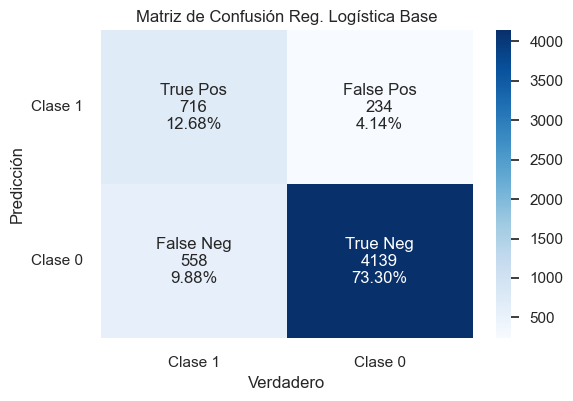

In [61]:
# Reordenamos la matriz de confusión para que tenga TP y FP en la primera fila, FN y TN en la segunda fila
cf_matrix_reordered = np.array([[cf_matrix[1, 1], cf_matrix[0, 1]],  # TP y FP
                                [cf_matrix[1, 0], cf_matrix[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered.flatten() / np.sum(cf_matrix_reordered)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Base', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

Análisis de matriz de confusión:

TN = 4138 Casos donde no llueve y predice que no llueve.

FP = 235 Casos donde no llueve pero predice que llueve.

FN = 559 Casos donde llueve pero predice que no llueve.

TP = 715 Casos donde llueve y predice que llueve correctamente.

##### Curva ROC y AUC 

In [62]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test_clean, y_probs_reglog)
roc_auc_rl = auc(fpr_rl, tpr_rl)

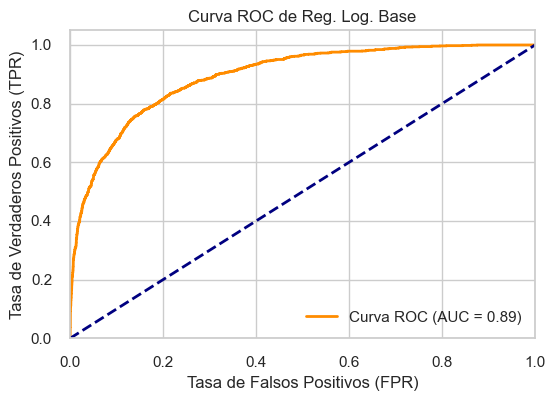

In [63]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_rl, tpr_rl, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Base')
plt.legend(loc="lower right")
plt.show()

### Regresión Logística Balanceada con Regularización Ridge.

Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es aprox. 77% (clase 0) / 23% (clase minoritaria 1) , el peso para la clase "1" será aproximadamente 3.35 veces mayor que el peso para la clase "0" (penaliza aprox. 3,35 veces más a la clase minoritaria que el de la clase mayoritaria.)

In [64]:
logistic_model_balanced = LogisticRegression(penalty='l2', random_state=42, class_weight= "balanced")
logistic_model_balanced.fit(x_train_clean, y_train_clean)
y_pred_balanced = logistic_model_balanced.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred_balanced))
print(confusion_matrix(y_test_clean, y_pred_balanced))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

[[3521  852]
 [ 243 1031]]


In [65]:
# Calcular Pondered Accuracy
pondered_accuracy_balanced = pondered_accuracy(y_test_clean, y_pred_balanced)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_balanced:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.8079


In [66]:
cf_matrix_b = confusion_matrix(y_test_clean, y_pred_balanced)

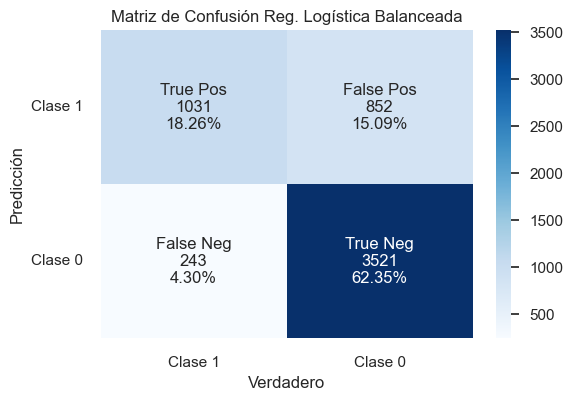

In [67]:
cf_matrix_reordered_b = np.array([[cf_matrix_b[1, 1], cf_matrix_b[0, 1]],  # TP y FP
                                [cf_matrix_b[1, 0], cf_matrix_b[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_b.flatten() / np.sum(cf_matrix_reordered_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_b, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

##### Curva ROC y AUC 

In [68]:
# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_ba, tpr_ba, thresholds_ba = roc_curve(y_test_clean, y_probs_balanced)
roc_auc = auc(fpr_ba, tpr_ba)

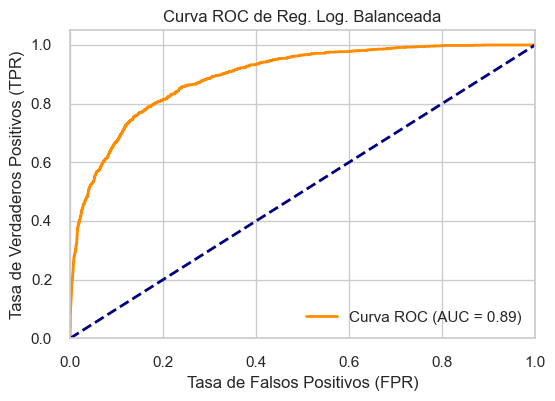

In [69]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_ba, tpr_ba, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada')
plt.legend(loc="lower right")
plt.show()

### Regresión Log. Balanceada con Regularización Lasso

In [70]:
# Crear un modelo de regresión logística con regularización L1 (Lasso)
# Ajusta el valor de 'C' para controlar la fuerza de la regularización (menos es más regularización)
# Un valor más pequeño de C=1/λ aumentará la regularización

logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=0.5, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1.5, solver='saga',random_state=42, class_weight= "balanced")

# Entrenar el modelo con tus datos de entrenamiento
logistic_model_balanced_regul.fit(x_train_clean, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = logistic_model_balanced_regul.predict(x_test_clean)

In [71]:
# Generar un informe de clasificación
reporte_clasificacion = classification_report(y_test_clean, y_pred_reg)
print("Informe de Clasificación:")
print(reporte_clasificacion)

# Calcular la matriz de confusión
matriz_confusion_regularizacion = confusion_matrix(y_test_clean, y_pred_reg)
print("Matriz de Confusión:")
print(matriz_confusion_regularizacion)

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

Matriz de Confusión:
[[3522  851]
 [ 243 1031]]


In [72]:
# Calcular Pondered Accuracy
pondered_accuracy_reg = pondered_accuracy(y_test_clean, y_pred_reg)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_reg:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.8080


In [73]:
cf_matrix_reg = confusion_matrix(y_test_clean, y_pred_reg)

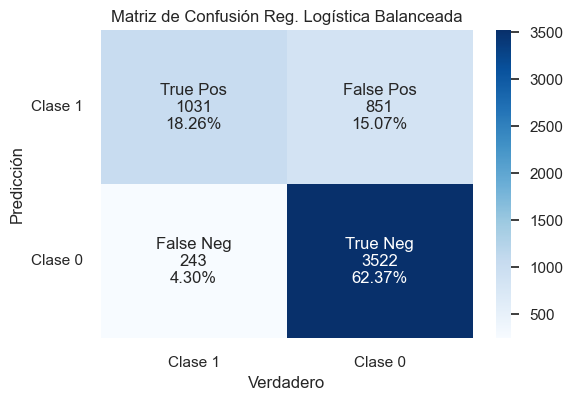

In [74]:
cf_matrix_reordered_reg = np.array([[cf_matrix_reg[1, 1], cf_matrix_reg[0, 1]],  # TP y FP
                                [cf_matrix_reg[1, 0], cf_matrix_reg[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_reg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_reg.flatten() / np.sum(cf_matrix_reordered_reg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_reg, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

##### Curva ROC y AUC 

In [75]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reg= logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_re, tpr_re, thresholds_re = roc_curve(y_test_clean, y_probs_reg)
roc_auc_re = auc(fpr_re, tpr_re)

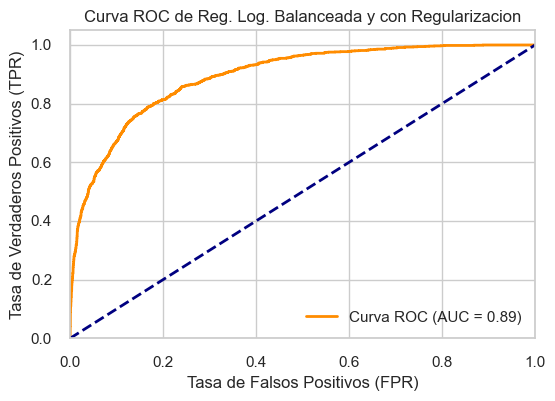

In [76]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_re)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada y con Regularizacion')
plt.legend(loc="lower right")
plt.show()

## 3. Modelos Base (Ingenuos) 

### Modelo Base Naive Bayes.

El clasificador Naive Bayes se considera "ingenuo" debido a la suposición simplificada que hace sobre la independencia de las características. GaussianNB: para características numéricas continuas (como temperatura, humedad, etc.) que pueden seguir una distribución normal.

In [77]:
from sklearn.naive_bayes import GaussianNB

# Crear el clasificador Naive Bayes
naive_bayes_model = GaussianNB()

# Entrenar el modelo
naive_bayes_model.fit(x_train_clean, y_train_clean)

# Hacer predicciones en el conjunto de prueba
y_pred_nb = naive_bayes_model.predict(x_test_clean)


In [78]:
# Mostrar el reporte de clasificación
print("Resultados de Naive Bayes:\n")
print(classification_report(y_test_clean, y_pred_nb))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_nb))
cf_matrix_nb= confusion_matrix(y_test_clean, y_pred_nb)


Resultados de Naive Bayes:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4373
           1       0.56      0.69      0.62      1274

    accuracy                           0.81      5647
   macro avg       0.73      0.77      0.75      5647
weighted avg       0.83      0.81      0.82      5647

Matriz de Confusión:

[[3694  679]
 [ 397  877]]


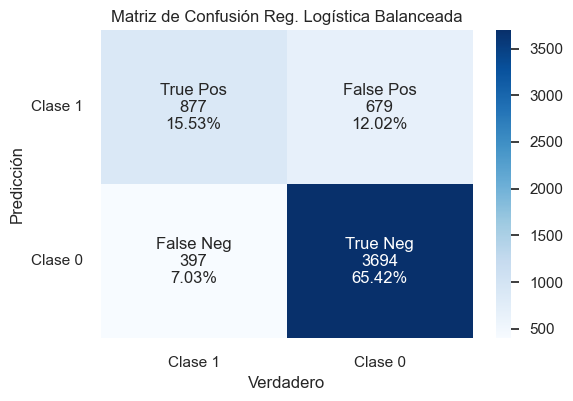

In [79]:
cf_matrix_reordered_nb = np.array([[cf_matrix_nb[1, 1], cf_matrix_nb[0, 1]],  # TP y FP
                                [cf_matrix_nb[1, 0], cf_matrix_nb[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_nb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_nb.flatten() / np.sum(cf_matrix_reordered_nb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_nb, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

In [80]:
# Calcular Pondered Accuracy
pondered_accuracy_nb = pondered_accuracy(y_test_clean, y_pred_nb)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_nb:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.7405


In [81]:
# Obtengo las probabilidades de predicción del modelo
y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

# Calculo la ROC y el AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_clean, y_probs_nb)
roc_auc = auc(fpr_nb, tpr_nb)

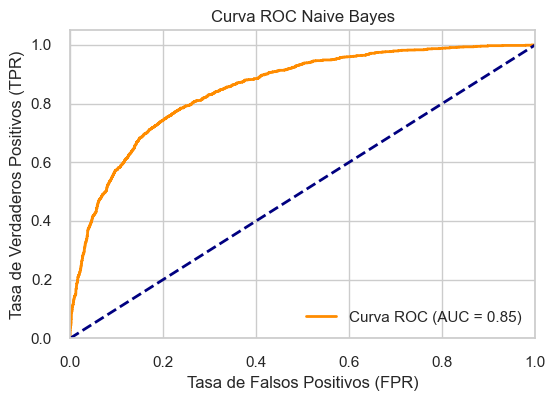

In [82]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Modelo Base: Basado en valor de variable Humedad (Humidity3pm).

In [83]:
media = X_train_imputed['Humidity3pm'].mean()
std = X_train_imputed['Humidity3pm'].std()
valor_60_escalado = (60-media) / std
valor_60_escalado

0.4578588657783258

In [84]:
y_pred_humidity = x_test_clean['Humidity3pm'].apply(lambda x:1 if x>valor_60_escalado else 0)
y_pred_humidity

0       0
1       1
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: Humidity3pm, Length: 5647, dtype: int64

In [85]:
y_pred_humidity.value_counts()

Humidity3pm
0    3562
1    2085
Name: count, dtype: int64

In [86]:
# Mostrar el reporte de clasificación
print("Resultados de Baseline por Humidity:\n")
print(classification_report(y_test_clean, y_pred_humidity))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_humidity))

Resultados de Baseline por Humidity:

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4373
           1       0.46      0.75      0.57      1274

    accuracy                           0.74      5647
   macro avg       0.68      0.75      0.69      5647
weighted avg       0.81      0.74      0.76      5647

Matriz de Confusión:

[[3245 1128]
 [ 317  957]]


In [87]:
# Calcular Pondered Accuracy
pondered_accuracy_humidity = pondered_accuracy(y_test_clean, y_pred_humidity)
print(f'Pondered Accuracy Reg. Logistica Base: {pondered_accuracy_humidity:.4f}')

Pondered Accuracy Reg. Logistica Base: 0.7481


In [88]:
cf_matrix_h= confusion_matrix(y_test_clean, y_pred_humidity)

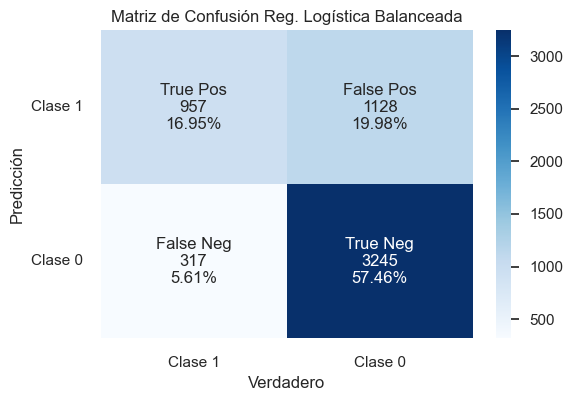

In [89]:
cf_matrix_reordered_h = np.array([[cf_matrix_h[1, 1], cf_matrix_h[0, 1]],  # TP y FP
                                [cf_matrix_h[1, 0], cf_matrix_h[0, 0]]])  # FN y TN
# Crear etiquetas para cada celda
labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_reordered_h.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_reordered_h.flatten() / np.sum(cf_matrix_reordered_h)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix_reordered_h, annot=labels, fmt="", cmap='Blues', cbar=True)
# Etiquetas y título del gráfico
plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Verdadero')
plt.ylabel('Predicción')
plt.xticks([0.5, 1.5], ['Clase 1', 'Clase 0'])  # Etiquetas de las clases en el eje x
plt.yticks([0.5, 1.5], ['Clase 1', 'Clase 0'], rotation=0)  # Etiquetas de las clases en el eje y
plt.show()

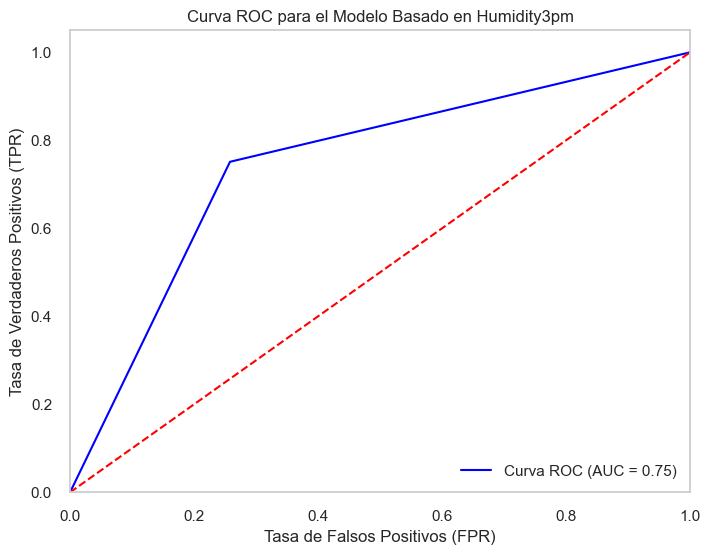

In [90]:
# Calcular las probabilidades para la curva ROC
# Asumimos que el valor de umbral para la clase positiva es valor_60_escalado
y_probs_humidity = y_pred_humidity.astype(int)

# Calcular FPR y TPR
fpr_hum, tpr_hum, thresholds_hum = roc_curve(y_test_clean, y_probs_humidity)

# Calcular el AUC
roc_auc_humidity = auc(fpr_hum, tpr_hum)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_hum, tpr_hum, color='blue', label=f'Curva ROC (AUC = {roc_auc_humidity:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Modelo Basado en Humidity3pm')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Comparación de Modelos

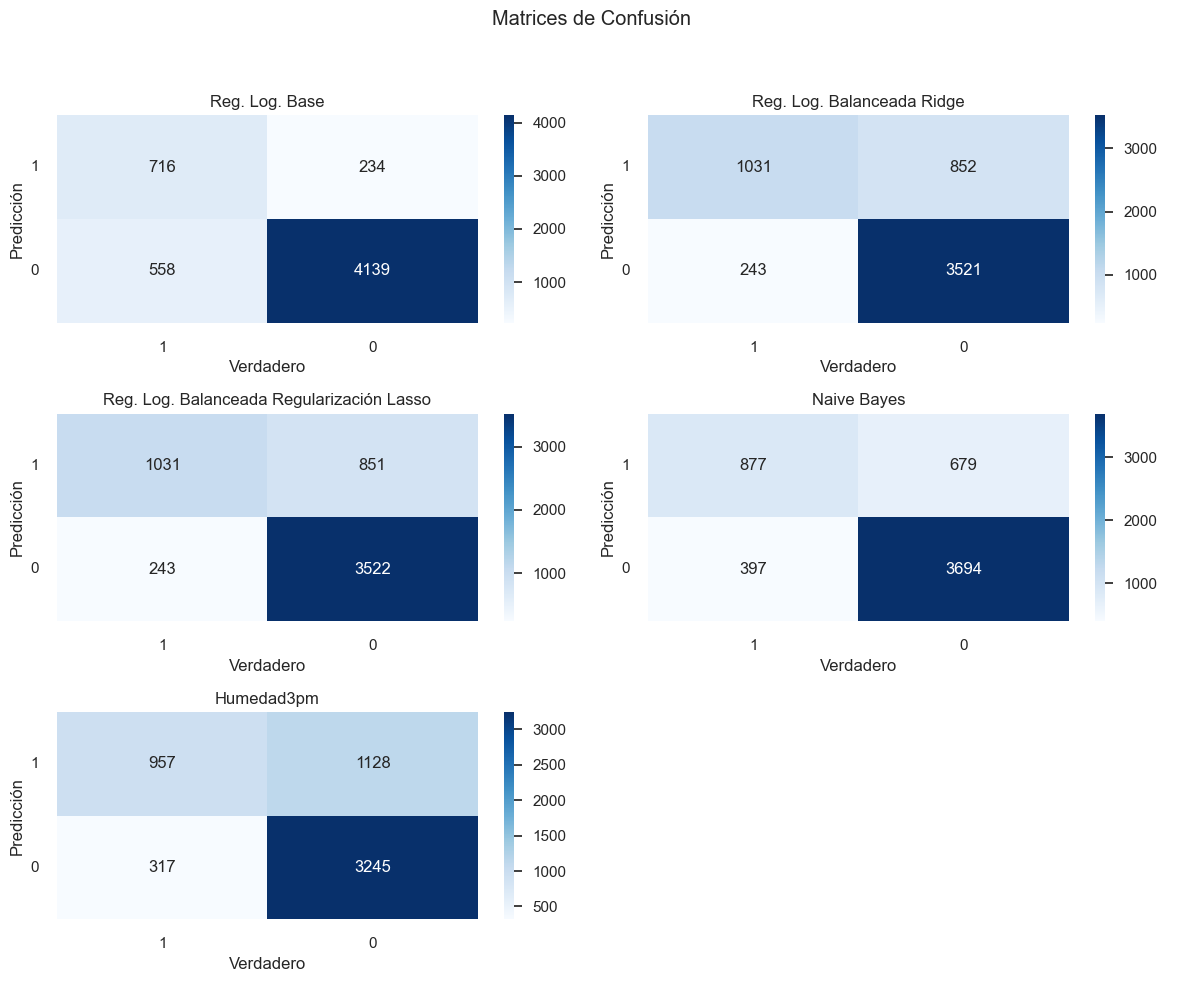

In [91]:

# Listado de matrices y títulos
matrices = [cf_matrix_reordered, cf_matrix_reordered_b, cf_matrix_reordered_reg, cf_matrix_reordered_nb, cf_matrix_reordered_h]
titles = ["Reg. Log. Base", "Reg. Log. Balanceada Ridge", "Reg. Log. Balanceada Regularización Lasso", "Naive Bayes", "Humedad3pm"]

# Configurar la figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
# Título para toda la figura
fig.suptitle("Matrices de Confusión")
# fig.suptitle("Matrices de Confusión", fontsize=16)

# Iterar sobre cada matriz y el subplot correspondiente
for i, ax in enumerate(axes.ravel()):
    if i < len(matrices):  # Asegúrate de que haya una matriz disponible para cada subplot
        matrix = matrices[i]
        # Crear etiquetas personalizadas
        labels = ["TP", "FP", "FN", "TN"]
        group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
        labels_custom = [f"{v1}\n{v2}" for v1, v2 in zip(labels, group_counts)]
        labels_custom = np.asarray(labels_custom).reshape(2, 2)
        # Graficar la matriz reordenada
        # sns.heatmap(matrix, annot=labels_custom, fmt="", cmap="Blues", ax=ax, cbar=True, square=True)
        sns.heatmap(matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel("Verdadero")
        ax.set_ylabel("Predicción")
        # Etiquetas de clase en los ejes
        ax.set_xticklabels(['1', '0'])
        ax.set_yticklabels(['1', '0'], rotation=0)
    else:
        ax.axis('off')  # Apagar cualquier subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


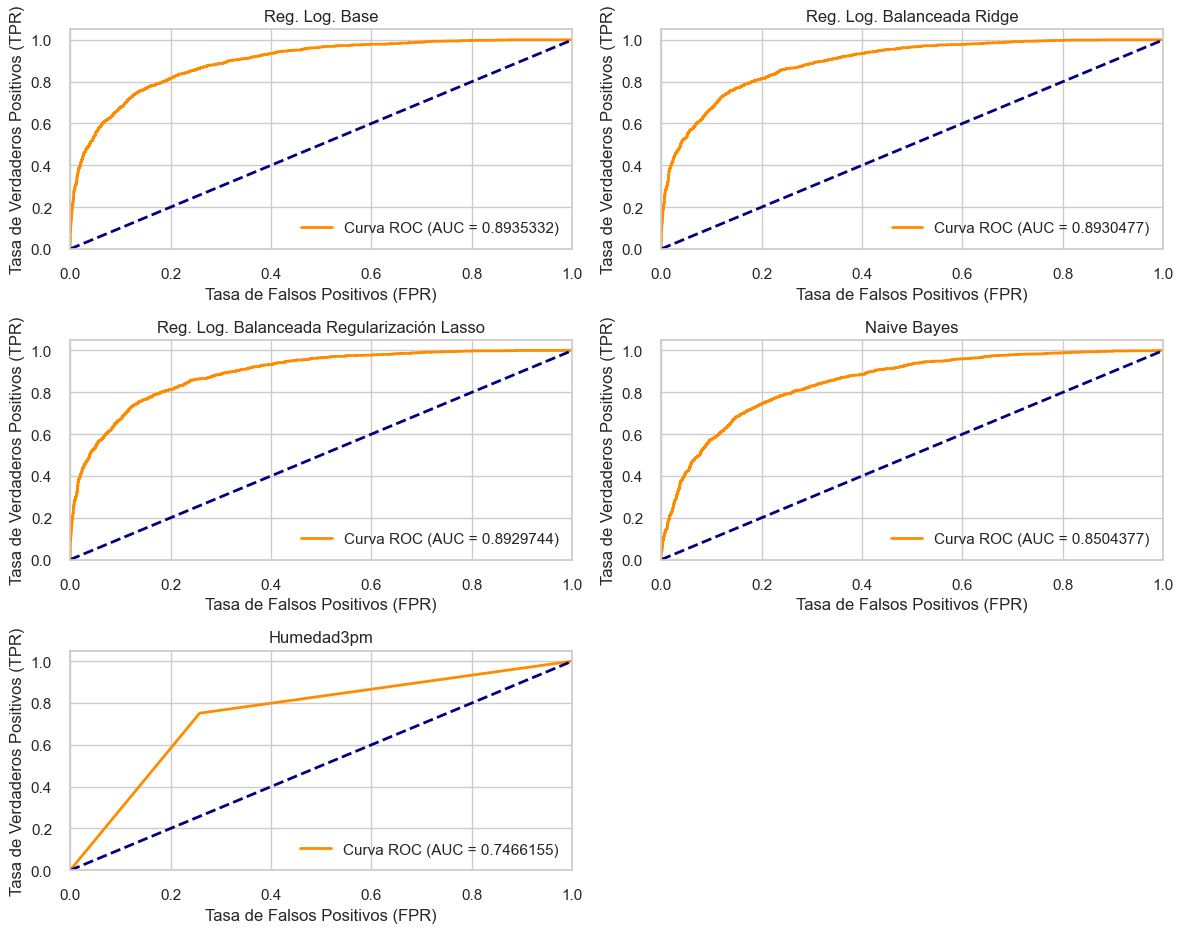

In [92]:
# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Títulos para cada subgráfico
titles = ["Reg. Log. Base", "Reg. Log. Balanceada Ridge", "Reg. Log. Balanceada Regularización Lasso", "Naive Bayes", "Humedad3pm"]

# Probabilidades y etiquetas de prueba para cada modelo
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg, y_probs_nb, y_probs_humidity]

for i, ax in enumerate(axes.ravel()):
    if i < len(y_probs_modelos):  # Verifica que haya y_probs_modelos disponibles
        fpr, tpr, thresholds = roc_curve(y_test_clean, y_probs_modelos[i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
        ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        ax.set_title(titles[i])
        ax.legend(loc="lower right")
    else:
        ax.axis('off')  # Oculta el subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [93]:
# Generar los informes de clasificación
report_reglog = classification_report(y_test_clean, y_pred, output_dict=True)
report_balanced = classification_report(y_test_clean, y_pred_balanced, output_dict=True)
report_regularized = classification_report(y_test_clean, y_pred_reg, output_dict=True)
report_base_nb = classification_report(y_test_clean, y_pred_nb, output_dict=True)
report_base_humidity = classification_report(y_test_clean, y_pred_humidity, output_dict=True)

#### Cuadro comparativo métricas.

Realizamos una observación general de todas las métricas.

In [94]:
# Extraer las métricas ( crea del df de métricas )
metrics = {
    "Modelo": [
        "Regresión Logística Base", 
        "Regres. Log. Balanceada Ridge", 
        "Reg. Log. Balanceada Lasso", 
        "Naive Bayes",
        "Modelo Base Humidity"
    ],
    "Accuracy": [
        report_reglog["accuracy"],
        report_balanced["accuracy"],
        report_regularized["accuracy"],
        report_base_nb["accuracy"],
        report_base_humidity["accuracy"]
    ],
    "Precision (Clase 0)": [
        report_reglog["0"]["precision"],
        report_balanced["0"]["precision"],
        report_regularized["0"]["precision"],
        report_base_nb["0"]["precision"],
        report_base_humidity["0"]["precision"]
    ],
    "Precision (Clase 1)": [
        report_reglog["1"]["precision"],
        report_balanced["1"]["precision"],
        report_regularized["1"]["precision"],
        report_base_nb["1"]["precision"],
        report_base_humidity["1"]["precision"]
    ],
    "Recall (Clase 0)": [
        report_reglog["0"]["recall"],
        report_balanced["0"]["recall"],
        report_regularized["0"]["recall"],
        report_base_nb["0"]["recall"],
        report_base_humidity["0"]["recall"]
    ],
    "Recall (Clase 1)": [
        report_reglog["1"]["recall"],
        report_balanced["1"]["recall"],
        report_regularized["1"]["recall"],
        report_base_nb["1"]["recall"],
        report_base_humidity["1"]["recall"]
    ],
    "F1 Score (Clase 0)": [
        report_reglog["0"]["f1-score"],
        report_balanced["0"]["f1-score"],
        report_regularized["0"]["f1-score"],
        report_base_nb["0"]["f1-score"],
        report_base_humidity["0"]["f1-score"]
    ],
    "F1 Score (Clase 1)": [
        report_reglog["1"]["f1-score"],
        report_balanced["1"]["f1-score"],
        report_regularized["1"]["f1-score"],
        report_base_nb["1"]["f1-score"],
        report_base_humidity["1"]["f1-score"]
    ],
    "Pondered Accuracy": [
        pondered_accuracy_rl, 
        pondered_accuracy_balanced, 
        pondered_accuracy_reg, 
        pondered_accuracy_nb,
        pondered_accuracy_humidity
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


Se observa que al Balancear (class_weight = balanced) mediante la discriminación de penalidad asignada a cada clase, para evitar que el modelo tienda a predecir la categoría mayoritaria, se mejora el recall de la clase minoritaria (Recall 1), pasando de 0.562 a 0.8092, que en TP se traduce en 716 a 1031 aciertos.


In [95]:
# GRÁFICO DE BARRAS DE MÉTRICAS SEPARADAS POR CLASES.
# Usar melt para incluir tanto la clase 0 como la clase 1 (La función melt() transforma el DataFrame para que las métricas estén en una forma "larga" en lugar de "ancha")
metrics_melted = metrics_df.melt(id_vars=["Modelo"], 
                                   value_vars=["Precision (Clase 0)", "Precision (Clase 1)", 
                                               "Recall (Clase 0)", "Recall (Clase 1)", 
                                               "F1 Score (Clase 0)", "F1 Score (Clase 1)"],
                                   var_name="Métrica", 
                                   value_name="Valor")

# Crear el gráfico de barras
fig = px.bar(metrics_melted, 
             x='Modelo', 
             y='Valor', 
             color='Métrica', 
             barmode='group',
             title='Comparativa de Métricas por Modelo y por clases')

fig.show()


#### Umbral óptimo.

Aclaración:
Se analiza el umbral óptimo de los modelos que presentan mejor Pondered Acuraccy y el modelo Base Humidity3pm.

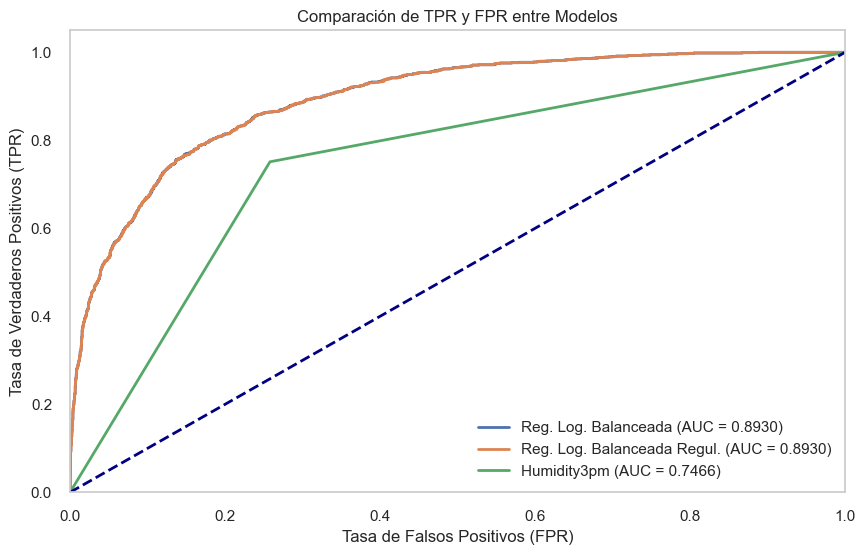

In [96]:
# Relación entre TPR/FPR de Curva ROC y AUC.

# Definir los modelos y sus TPR y FPR
model_names = ["Reg. Log. Balanceada", "Reg. Log. Balanceada Regul.", "Humidity3pm"]
tpr_values = [tpr_ba, tpr_re, tpr_hum]
fpr_values = [fpr_ba, fpr_re, fpr_hum]
y_probs_modelos = [y_probs_balanced, y_probs_reg, y_probs_humidity]  # Probabilidades de cada modelo

# Crear el gráfico
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    # Calcular AUC para cada modelo
    auc_value = roc_auc_score(y_test_clean, y_probs_modelos[i])

    # Graficar TPR vs FPR
    plt.plot(fpr_values[i], tpr_values[i], lw=2, label=f'{model} (AUC = {auc_value:.4f})')

# Agregar líneas de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal

# Configurar el gráfico
plt.title("Comparación de TPR y FPR entre Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.grid()

# Mostrar el gráfico
plt.show()


Umbral óptimo: Calcular la distancia euclidiana de cada punto de la curva ROC a punto(0,1) o AUC=1.

Interesa la distancia mínima: qué tan "cerca" se encuentra de la esquina superior izquierda de la curva ROC, lo que indica un mejor equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.

$\text{distancia} = \sqrt{(\text{FPR})^2 + (1 - \text{TPR})^2}$

Objetivo: Ajustar umbrales para maximizar el pondered accuracy.

Pasos: 1) Obtener las Probabilidades de la Clase Positiva

       2) Curva ROC y los Umbrales : función roc_curve para calcular la TPR, FPR y los umbrales para cada modelo.

       3) Encontrar el Umbral Óptimo: 

       4) Hacer Predicciones Usando el Umbral Óptimo
       
       5) Evaluar el Rendimiento: Pondered Accuracy para cada modelo utilizando las predicciones ajustadas

NOTA: 

Cálculos ya realizados con antelación por modelo.:

**Predicciones de los distintos modelos:**
y_pred_balanced ,
y_pred_reg ,
y_pred_humidity

**1) Predicciones de Probabilidades**  

Probabilidades de las clases positivas para cada uno de los modelos (método predict_proba):

y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]

y_probs_reg = logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]

y_probs_humidity

**2) Curva ROC y los Umbrales ( thresholds) : función roc_curve para calcular la TPR, FPR y los umbrales.**

In [97]:
# # MARCE

# # Calcula Youden's J statistic para cada umbral
# J_scores = tpr_ba - fpr_ba
# optimal_idx = J_scores.argmax()
# optimal_threshold = thresholds_ba[optimal_idx]

# print("Umbral óptimo:", optimal_threshold)

Mejor umbral: 0.519433420266038
Distancia mínima al punto perfecto: 0.26932073026017395


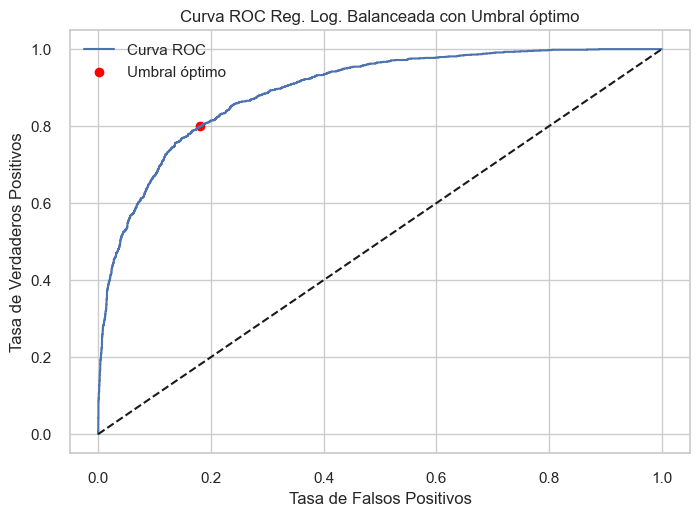

In [98]:
# Observamos Gráficamente Umbral Optimo unicamente para Reg. Logistica Balanceada (distancia a punto (0,1) --> donde AUC = 1)
"""Calcula la curva ROC con las etiquetas verdaderas y las probabilidades de clase positiva.
   Calcula la distancia euclidiana de cada punto de la curva al punto perfecto (0,1).
   Encuentra el umbral que minimiza esta distancia
"""

# Calcular la distancia al punto perfecto
distances = np.sqrt(fpr_ba**2 + (1 - tpr_ba)**2)

# Encontrar el índice del umbral que minimiza la distancia
min_distance_index = np.argmin(distances)
best_threshold = thresholds_ba[min_distance_index]
best_distance = distances[min_distance_index]

print("Mejor umbral:", best_threshold)
print("Distancia mínima al punto perfecto:", best_distance)

import matplotlib.pyplot as plt

plt.plot(fpr_ba, tpr_ba, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.scatter(fpr_ba[min_distance_index], tpr_ba[min_distance_index], color='red', label='Umbral óptimo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Reg. Log. Balanceada con Umbral óptimo')
plt.legend()
plt.show()

In [99]:
# 3) Umbral Óptimo para modelo Balanceado, con Regularizacion y Base " Humidity3pm" y distancia mínima que los determina.
def find_optimal_threshold(fpr, tpr, thresholds):
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)  # Distancia
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    minimum_distance = distances[optimal_idx]
    return optimal_threshold, minimum_distance

# Encontrar umbrales óptimos
optimal_threshold_balanced, min_distance_balanced = find_optimal_threshold(fpr_ba, tpr_ba, thresholds_ba)
optimal_threshold_reg, min_distance_reg = find_optimal_threshold(fpr_re, tpr_re, thresholds_re)
optimal_threshold_hum, min_distance_hum = find_optimal_threshold(fpr_hum, tpr_hum, thresholds_hum)

# Imprimir resultados
print(f'Umbral óptimo (Reg. Log. Balanceada): {optimal_threshold_balanced:.2f}, Distancia mínima: {min_distance_balanced:.4f}')
print(f'Umbral óptimo (Reg. Log. Balanceada Regul.): {optimal_threshold_reg:.2f}, Distancia mínima: {min_distance_reg:.4f}')
print(f'Umbral óptimo (Humidity3pm): {optimal_threshold_hum:.2f}, Distancia mínima: {min_distance_hum:.4f}')


Umbral óptimo (Reg. Log. Balanceada): 0.52, Distancia mínima: 0.2693
Umbral óptimo (Reg. Log. Balanceada Regul.): 0.52, Distancia mínima: 0.2683
Umbral óptimo (Humidity3pm): 1.00, Distancia mínima: 0.3584


In [100]:
# 4) Predicciones finales usando los umbrales óptimos
y_pred_optimal_balanced = (y_probs_balanced >= optimal_threshold_balanced).astype(int)
y_pred_optimal_reg = (y_probs_reg >= optimal_threshold_reg).astype(int)
y_pred_optimal_hum = (y_probs_humidity >= optimal_threshold_hum).astype(int)

In [101]:
# ACA

# 5) Observación de rendimiento de modelos ajuste de umbral.

# Métricas modelo balanceado optimizado.
f1_balanced = f1_score(y_test_clean, y_pred_optimal_balanced)
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced)
print(f'F1 Score (Reg. Log. Balanceada): {f1_balanced:.4f}, Balanced Accuracy: {balanced_acc_balanced:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_balanced))

# Métricas modelo balanceado y regularización
f1_reg = f1_score(y_test_clean, y_pred_optimal_reg)
balanced_acc_reg = balanced_accuracy_score(y_test_clean, y_pred_optimal_reg)
print(f'F1 Score (Reg. Log. Balanceada Regul.): {f1_reg:.4f}, Balanced Accuracy: {balanced_acc_reg:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_reg))



F1 Score (Reg. Log. Balanceada): 0.6615, Balanced Accuracy: 0.8098
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4373
           1       0.56      0.80      0.66      1274

    accuracy                           0.82      5647
   macro avg       0.75      0.81      0.77      5647
weighted avg       0.85      0.82      0.83      5647

F1 Score (Reg. Log. Balanceada Regul.): 0.6626, Balanced Accuracy: 0.8106
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4373
           1       0.57      0.80      0.66      1274

    accuracy                           0.82      5647
   macro avg       0.75      0.81      0.77      5647
weighted avg       0.85      0.82      0.83      5647



In [102]:
# 5) Observación de rendimiento general de todas las métricas con ajuste de umbral (métricas con umbral óptimo)
metrics = {
    "Modelo": [
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada",  
        "Humidity3pm"
    ],
    "Accuracy": [
        accuracy_score(y_test_clean, y_pred_optimal_balanced),
        accuracy_score(y_test_clean, y_pred_optimal_reg),
        accuracy_score(y_test_clean, y_pred_optimal_hum)
    ],
    "Precision (Clase 0)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Precision (Clase 1)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Recall (Clase 0)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Recall (Clase 1)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "F1 Score (Clase 0)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "F1 Score (Clase 1)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Pondered Accuracy": [
        pondered_accuracy(y_test_clean, y_pred_optimal_balanced), 
        pondered_accuracy(y_test_clean, y_pred_optimal_reg), 
        pondered_accuracy(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


### Métrica elegida -con ajuste de Umbral óptimo: Pondered Accuracy-

In [103]:
# Calcular las métricas para cada modelo con el umbral óptimo
metrics = {
    "Modelo": [ 
        "Regres. Log. Balanceada Regularizada Ridge", 
        "Reg. Log. Balanceada Regularizada Lasso", 
        "Humidity3pm"
    ],
    "Pondered Accuracy": [
        pondered_accuracy(y_test_clean, y_pred_optimal_balanced), 
        pondered_accuracy(y_test_clean, y_pred_optimal_reg), 
        pondered_accuracy(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df_umbral = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df_umbral.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


Comentarios

En el contexto de los datos proporcionados, nos interesa maximizar el **Pondered Accuracy**.

Esta es una métrica personalizada, diseñada para buscar altos Recall de clase 1 y 0, ponderando al doble el Recall de la Clase 1.

Recordemos que la target que indica "si llueve" (Clase positiva: RainTomorrow = 1) es la minoritaria y "no llueve" (Clase negativa =0), donde "no llueve" es la clase mayoritaria.

Mediante la aplicacion de técnicas de balanceo de datos conseguimos mejorar la métrica Pondered Accuracy.


**Resultado**: El modelo con el cual se obtiene el mejor fitting general es el de Regresión Logística Balanceado y Regularizado.
Este modelo presenta un Pondered Accuracy de 0.807248.

Los modelos superan al modelo Base elegido "Humidity3pm".

## Punto 4: Optimización de selección de Hiperparámetros.

### Validación Cruzada - KFolds

Se evalúa con validación cruzada el modelo elegido, balanceado y con regularización L1, observando las métricas recall de clase 1 y balanced accuracy.

La validación cruzada es una técnica que se utiliza para evaluar la capacidad de generalización de un modelo de machine learning. Al separar el conjunto de validación dentro del conjunto de entrenamiento existe una fuga de datos que está aceptada.

Tres estrategias de validación cruzada:

1) KFold: Divide el conjunto de datos en n partes (o "folds"). En cada iteración, se entrena el modelo con (n-1) de esos folds y se valida con el fold restante. La opción shuffle=True asegura que los datos se barajen antes de dividirlos, y random_state=42 establece una semilla para la aleatoriedad, asegurando que los resultados sean reproducibles.

2) StratifiedKFold: Similar a KFold, pero intenta mantener la misma proporción de clases en cada fold. Esto es útil si tienes un conjunto de datos desbalanceado.

3) Leave-One-Out: Una forma extrema de validación cruzada donde para cada muestra en el conjunto de datos, el modelo se entrena con todas las muestras menos una, y se valida con esa única muestra. Esto se repite para cada muestra en el conjunto

Se elige la estrategia KFolds.

In [104]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(pondered_accuracy)
# Evaluar el modelo usando validación cruzada
scores_train = cross_val_score(logistic_model_balanced_regul, x_train_clean, y_train_clean, cv=cv, scoring=scorer)

print(f"Puntuaciones de validación cruzada (pondered_accuracy): {scores_train}")
print(f"Media de las puntuaciones (pondered_accuracy): {scores_train.mean():.4f}")
print(f"Desvío Standart de las puntuaciones (pondered_accuracy): {scores_train.std():.4f}")

Puntuaciones de validación cruzada (pondered_accuracy): [0.80645157 0.81002557 0.7989144  0.81214384 0.80658117]
Media de las puntuaciones (pondered_accuracy): 0.8068
Desvío Standart de las puntuaciones (pondered_accuracy): 0.0045


Rendimiento General: Una media alta indica que el modelo es eficaz para hacer predicciones.

Robustez: Un desvío estándar bajo indica que es menos probable que el modelo esté sesgado por los datos de entrenamiento y se vea afectado por la variabilidad en los datos.

### Métodos de búsqueda

La búsqueda de los mejores hiperparámetros se realiza a través de las siguientes técnicas:

* Grid Search: GridSearchCV utiliza validación cruzada para encontrar la mejor combinación y mejorar el rendimiento, barriendo toda la grilla, es decir todas las combinaciones posibles de hiperparámentros. Este método es más costoso computacionalmente y da las mejores métricas.
* Random Search: RandomizedSearchCV utiliza validación cruzada para encontrar la mejor combinación y mejorar el rendimiento, eligiendo en forma aleatoria algunos puntos de la grilla, es decir, algunas combinaciones de hiperparámentros.
* Enfoque Bayesiano: el framework optuna hace una búsqueda secuencial de hiperparámetros que internamente usa el enfoque Bayesiano.

Con todas las técnicas se utiliza el solver 'saga', ya que es el único que ofrece compatibilidad con los tres tipos de regularización (l1, l2 y elasticnet).


Los hiperparámetros a optimizar son:

**C:** = 1/λ Hiperparámetro de regularización que controla la penalización de errores en la clasificación.
        Valores más altos de C pueden llevar a un modelo más complejo (menor regularización).
        Valores más bajos hacen que el modelo sea más simple (mayor regularización).

        Escala Logarítmica: Usar np.logspace(-3, 3, num=10) genera 10 valores entre 10^−3  y 10^3, lo que permite explorar un rango amplio de valores.

**penalty:** Tipo de penalización que se aplica al modelo.

        'l1': Regularización Lasso, que puede llevar a que algunos coeficientes sean cero.

        'l2': Regularización Ridge, que penaliza el tamaño de los coeficientes.

        'elasticnet': Combina ambos tipos de regularización

**max_iter**: Número máximo de iteraciones para el optimizador.
         Un número mayor de iteraciones permite que el modelo converja mejor, pero también incrementa el tiempo de computación.

        Rango: range(50, 1001, 50) indica que se probarán valores entre 50 y 1000 (incluyendo 1000) con saltos de 50.


**class_weight**: Manejo del balance de clases, especialmente útil en conjuntos de datos desbalanceados.

        'balanced': Ajusta los pesos inversamente proporcionales a las frecuencias de las clases.

        None: No aplica pesos.

#### Parámetros

In [105]:
C = (np.logspace(-3, 3, num=10))
# max_iter = [10, 50, 100, 200, 500]
max_iter = np.arange(50, 1001, 50)
solver_saga = 'saga'
params_list = [
    {
        'penalty': ['l1', 'l2',None],
        'solver' : [solver_saga],
        'class_weight' : ['balanced',None],
        'C' : C,
        'max_iter' : max_iter,
    },
    {
        'penalty': ['elasticnet'],
        'solver' : [solver_saga],
        'class_weight' : ['balanced',None],
        'C' : C,
        'max_iter' : max_iter,
        'l1_ratio' : [0.2, 0.4, 0.6, 0.8]#[n/10  for n in range(0,11,1)]
    },
]

#### Grid Search

In [ ]:
# scorer = make_scorer(pondered_accuracy)
# best_grid_params = None
# best_metric = -1
# for params in params_list:
#     grid_search = GridSearchCV(LogisticRegression(random_state=42), params, cv=5, scoring=scorer, n_jobs=-1)
#     grid_search.fit(x_train_clean, y_train_clean)
#     best_grid_score = grid_search.best_score_
#     best_grid_params_parcial = grid_search.best_params_
#     if ( best_grid_score > best_metric ):
#         best_metric = best_grid_score
#         best_grid_params = best_grid_params_parcial

In [ ]:
# # Obtener el mejor modelo y sus hiperparámetros
# best_grid_model = LogisticRegression(**best_grid_params, random_state=42)
# best_grid_model.fit(x_train_clean, y_train_clean)

# # Guardar modelo e hiperparámetros
# joblib.dump(best_grid_model, 'best_grid_model.joblib')
# print("Mejor modelo guardado exitosamente.")

# # Convertir valores a tipos serializables en JSON
# best_grid_params_serializable = {key: int(value) if isinstance(value, np.integer) else float(value) if isinstance(value, np.floating) else value for key, value in best_grid_params.items()}

# # Guardar los mejores parámetros en un archivo JSON
# with open('best_grid_params.json', 'w') as archivo:
#     json.dump(best_grid_params_serializable, archivo, indent=4)
# print("Mejores hiperparámetros guardados exitosamente.")

# # Guardar los mejores parámetros en un archivo JSON
# with open('best_grid_score.json', 'w') as archivo:
#     json.dump(best_grid_score, archivo, indent=4) 

LogisticRegression(C=1, class_weight='balanced', max_iter=50, penalty='l1',
                   random_state=42, solver='saga')

In [109]:
# Obtener el mejor modelo y sus hiperparámetros
# best_grid_model = LogisticRegression(**best_grid_params, random_state=42)
# best_grid_model.fit(x_train_clean, y_train_clean)
# Cargar el modelo guardado
best_grid_model = joblib.load('best_grid_model.joblib')

# Cargar los mejores parámetros desde el archivo JSON
with open('best_grid_params.json', 'r') as archivo:
    best_grid_params = json.load(archivo)

with open('best_grid_score.json', 'r') as archivo:
    best_grid_score = json.load(archivo)

print("Modelo y parámetros cargados exitosamente.")

# Calcular las métricas en el conjunto de prueba
y_pred_grid = best_grid_model.predict(x_test_clean)
test_pondered_accuracy_grid = pondered_accuracy(y_test_clean, y_pred_grid)

print(f"Mejores parámetros del grid: {best_grid_params}")
print(f"Pondered accuracy en train: {best_grid_score}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_grid}")

Modelo y parámetros cargados exitosamente.
Mejores parámetros del grid: {'C': 10.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Pondered accuracy en train: 0.8050165191050992
Pondered accuracy en test: 0.8083445307972439


#### Random Search

Se entrenan 50 conjuntos de hiperparámetros (n_iter=50 )

Se prueban opciones de búsqueda por listas de valores específicos y por rango de valores para C y max-iter.

In [110]:
scorer = make_scorer(pondered_accuracy)
best_random_params = None
best_metric = -1
for params in params_list:
    random_search = RandomizedSearchCV(LogisticRegression(random_state=42), params, cv=5, scoring=scorer, n_jobs=-1, n_iter=50)
    random_search.fit(x_train_clean, y_train_clean)
    best_random_score = random_search.best_score_
    best_random_params_parcial = random_search.best_params_
    if ( best_random_score > best_metric ):
        best_metric = best_random_score
        best_random_params = best_random_params_parcial

In [111]:
# Obtener el mejor modelo y sus hiperparámetros
best_random_model = LogisticRegression(**best_random_params, random_state=42)
best_random_model.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de prueba
y_pred_random = best_random_model.predict(x_test_clean)
test_pondered_accuracy_random = pondered_accuracy(y_test_clean, y_pred_random)

print(f"Mejores parámetros del random: {best_random_params}")
print(f"Pondered accuracy en train: {best_random_score}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_random}")

Mejores parámetros del random: {'solver': 'saga', 'penalty': None, 'max_iter': 950, 'class_weight': 'balanced', 'C': 0.004641588833612777}
Pondered accuracy en train: 0.8048835845753551
Pondered accuracy en test: 0.8083445307972439


#### Optuna con validación cruzada

Se prueban dos opciones de búsqueda para C:
* C = trial.suggest_categorical('C', [0.001, 0.1, 1, 10, 1000])
  Define C como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
  Menos carga computacional, ya que se exploran solo valores discretos específicos. Es útil cuando se conocen los valores que suelen funcionar bien o se quiere reducir el tiempo de optimización.

* C = trial.suggest_float('C', 0.001, 1000, log=True)
  Define C como una variable continua en el rango de 0.001 a 1000. Al especificar log=True, se indica que C debe explorarse en una escala logarítmica. Esto permite que el optimizador explore valores en una escala amplia. Se logra mayor precisión en la búsqueda.

Se prueban dos opciones de búsqueda para max_iter:
* max_iter = trial.suggest_categorical('max_iter', [10, 50, 100, 200, 500, 1000])
  Define max_iter como una variable categórica. El optimizador sólo considerará los valores en la lista dada.
* max_iter = trial.suggest_int('max_iter', 50, 1000)
  Define max_iter como una variable continua en el rango de 50 a 1000. Esto permite que el optimizador explore valores en una escala amplia y encuentre cualquier valor entre 50 y 1000.

In [112]:
# Definir la función objetivo para Optuna con validación cruzada k-folds
def objective(trial):
    # Definir los hiperparámetros que Optuna optimizará
    # C = trial.suggest_categorical('C', [0.001, 0.1, 1, 10, 1000])
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    max_iter = trial.suggest_categorical('max_iter',  [10, 50, 100, 200, 500, 1000])
    # max_iter = trial.suggest_int('max_iter', 50, 1000)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    solver = trial.suggest_categorical('solver', ['saga'])
    # Si se selecciona elasticnet, establecer l1_ratio; de lo contrario, l1_ratio es None
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    # Crear el modelo con los parámetros actuales
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        l1_ratio=l1_ratio,
        random_state=42,
        dual=False
    )
    # Definir el método de validación cruzada y la métrica de evaluación
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(pondered_accuracy)
    # Usar cross_val_score para calcular el pondered_accuracy promedio en k-folds
    scores = cross_val_score(model, x_train_clean, y_train_clean, cv=skf, scoring=scorer)
    mean_score = scores.mean()
    # Devolver el pondered_accuracy promedio
    return mean_score

# Crear el estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Obtener el mejor modelo y sus hiperparámetros
best_optuna_params_kfolds = study.best_params
best_optuna_model_kfolds = LogisticRegression(**best_optuna_params_kfolds, random_state=42, dual=False)
best_optuna_model_kfolds.fit(x_train_clean, y_train_clean)

# Calcular las métricas en el conjunto de train
y_pred_train_op_kfolds = best_optuna_model_kfolds.predict(x_train_clean)
train_pondered_accuracy_op_kfolds = pondered_accuracy(y_train_clean, y_pred_train_op_kfolds)
# Calcular las métricas en el conjunto de test
y_pred_test_op_kfolds = best_optuna_model_kfolds.predict(x_test_clean)
test_pondered_accuracy_op_kfolds = pondered_accuracy(y_test_clean, y_pred_test_op_kfolds)

# Imprimir las métricas
print(f"Mejores parámetros de Optuna: {best_optuna_params_kfolds}")
print(f"Pondered Accuracy en train: {train_pondered_accuracy_op_kfolds:.4f}")
print(f"Pondered Accuracy en test: {test_pondered_accuracy_op_kfolds:.4f}")

[I 2024-11-23 11:12:36,490] A new study created in memory with name: no-name-440cf579-1e78-4e6f-aba9-9ce435ebbd34
[I 2024-11-23 11:12:37,244] Trial 0 finished with value: 0.8056589512366823 and parameters: {'C': 38.54705140108405, 'penalty': 'l1', 'max_iter': 10, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.8056589512366823.
[I 2024-11-23 11:12:41,126] Trial 1 finished with value: 0.6913324585492502 and parameters: {'C': 0.006482906232493366, 'penalty': None, 'max_iter': 500, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.8056589512366823.
[I 2024-11-23 11:12:41,791] Trial 2 finished with value: 0.8020772589465371 and parameters: {'C': 0.0031733424722418043, 'penalty': 'elasticnet', 'max_iter': 10, 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.40630587419559594}. Best is trial 0 with value: 0.8056589512366823.
[I 2024-11-23 11:12:45,591] Trial 3 finished with value: 0.6913324585492502 and parameters: {'C': 230.217912

Mejores parámetros de Optuna: {'C': 111.94973038024, 'penalty': 'l1', 'max_iter': 50, 'class_weight': 'balanced', 'solver': 'saga'}
Pondered Accuracy en train: 0.8081
Pondered Accuracy en test: 0.8083


#### Comparación de métodos

In [110]:
best_grid_params

{'C': 10.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [114]:
best_random_params

{'solver': 'saga',
 'penalty': None,
 'max_iter': 950,
 'class_weight': 'balanced',
 'C': 0.004641588833612777}

In [115]:
best_optuna_params_kfolds

{'C': 111.94973038024,
 'penalty': 'l1',
 'max_iter': 50,
 'class_weight': 'balanced',
 'solver': 'saga'}

In [111]:
print("Grid Search Pondered Accuracy:", test_pondered_accuracy_grid)
print("Random Search Pondered Accuracy:", test_pondered_accuracy_random)
print("Optuna K-Folds Pondered Accuracy:", test_pondered_accuracy_op_kfolds)

Grid Search Pondered Accuracy: 0.8083445307972439


NameError: name 'test_pondered_accuracy_random' is not defined

El método elegido para la optimización es GridSearchCV porque realiza una búsqueda más exhaustiva, analizando todas las combinaciones posibles de hiperparámetros.

## Punto 5: Explicabilidad -SHARP-

In [117]:
# # Construyo el modelo que reporta la mejor métrica 
# model = LogisticRegression(C= 1, class_weight= 'balanced', max_iter= 10, penalty= 'l2', solver= 'lbfgs',random_state=42)
# model.fit(x_train_clean,y_train_clean)
# y_pred = model.predict(x_test_clean)

In [112]:
# Cambio el tipo de dato a array para evitar problemas con los métodos de sharp
array_x_train_clean = np.array(x_train_clean)
array_x_test_clean = np.array(x_test_clean)
features = x_train_clean.columns

In [113]:
# Crea un objeto explainer SHAP y observo el valor esperado
explainer = shap.LinearExplainer(best_grid_model,array_x_train_clean , feature_names = features)
explainer.expected_value

-1.1130562954191119

El logaritmo de las chances promedio es, aproximadamente, 1.13 NEGATIVO, lo cual indica que el modelo predice que la mayoría de las muestran pertenecen a la clase 0, es decir, hay más muestras sobre las cuales se predice que al día siguiente no va a llover que muestras sobre las cuales el modelo predice lo contrario. 

In [114]:
# Calcula los valores SHAP para un conjunto de ejemplos de test
shap_values = explainer.shap_values(array_x_test_clean)

### Interpretabilidad **local**
Interesa analizar la explicabilidad de una muestra para la cual la predicción de probabilidad de que pertenezca a la clase 1 sea la máxima observada

In [124]:
y_pred = best_grid_model.predict_proba(array_x_test_clean)
idx_max_proba_clase_1 = y_pred[:,1].argmax()
y_pred[idx_max_proba_clase_1]

array([6.41843652e-04, 9.99358156e-01])

Nuestro modelo predice para esta muestra una probabilidad de pertenencia a la clase 1 de 0.9993

In [117]:
best_grid_model.predict(array_x_test_clean)[idx_max_proba_clase_1]

1

In [123]:
shap_value_obs_max_proba_clase_1 = shap_values[idx_max_proba_clase_1]
peso_features = pd.Series(shap_value_obs_max_proba_clase_1,index=x_train_clean.columns).sort_values(ascending=False)

In [124]:
# Se analiza cuáles son las features que explicarían por qué el logaritmo de las chances de esta obs es mayor al valor base  
peso_features[peso_features>0]

WindGustSpeed    5.878566
Humidity3pm      2.962941
Pressure3pm      1.287961
Rainfall         0.478217
RainToday_Yes    0.300382
MaxTemp          0.285202
MinTemp          0.266357
Humidity9am      0.183769
Month_may        0.173512
Month_ene        0.026547
Cloud3pm         0.025463
Month_mar        0.021130
Sunshine         0.010881
WindGustDir_S    0.010840
Month_nov        0.009656
Month_feb        0.006926
Month_dic        0.006235
Month_sep        0.002175
Cloud9am         0.000733
dtype: float64

In [125]:
# Se analiza cuáles son las features que explicarían por qué el logaritmo de las chances de esta obs es menor al valor base
peso_features[peso_features<0]

Month_jun       -0.000027
Month_oct       -0.000717
Temp9am         -0.003325
Month_jul       -0.006621
Evaporation     -0.014841
Month_ago       -0.017990
WindDir3pm_N    -0.018442
WindDir9am_W    -0.021662
WindGustDir_W   -0.021892
WindGustDir_N   -0.021930
WindDir3pm_W    -0.028390
WindDir9am_S    -0.033273
Latitude        -0.041829
WindDir3pm_S    -0.060321
Longitude       -0.085482
WindDir9am_N    -0.087247
WindSpeed9am    -0.159652
Temp3pm         -0.252543
Pressure9am     -0.564938
WindSpeed3pm    -2.032790
dtype: float64

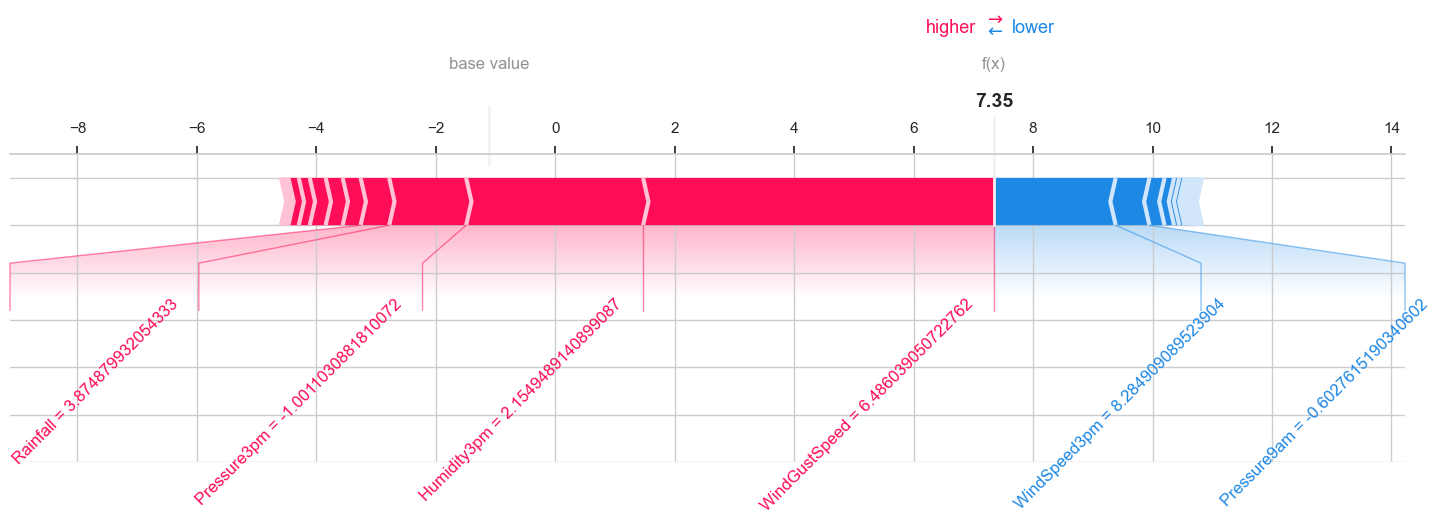

In [126]:
shap.force_plot(explainer.expected_value, shap_values[idx_max_proba_clase_1],
                array_x_test_clean[idx_max_proba_clase_1], feature_names=features,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

El logaritmo de las chances para esta observación es de 7.35, bien alejado del valor base esperado de, aproximadamente, -1.13, entre las features que realizan el mayor aporte para explicar por qué la predicción de probabilidad de lluvia al día siguiente es significativamente elevada se encuentran: la velocidad de las ráfagas de viento (alta), la humedad de las 3 p.m (alta), la presión (baja), entre las principales. Sin embargo, no todas las features se comportan de esta manera, pues se observan que 20 features que adoptan valores que contrarestan este efecto, la más importante operando en el sentido contrario es la velocidad del viento de las 3 p.m 

In [127]:
explanation = shap.Explanation(values=shap_values[idx_max_proba_clase_1],
                               base_values=explainer.expected_value,
                               feature_names=features)

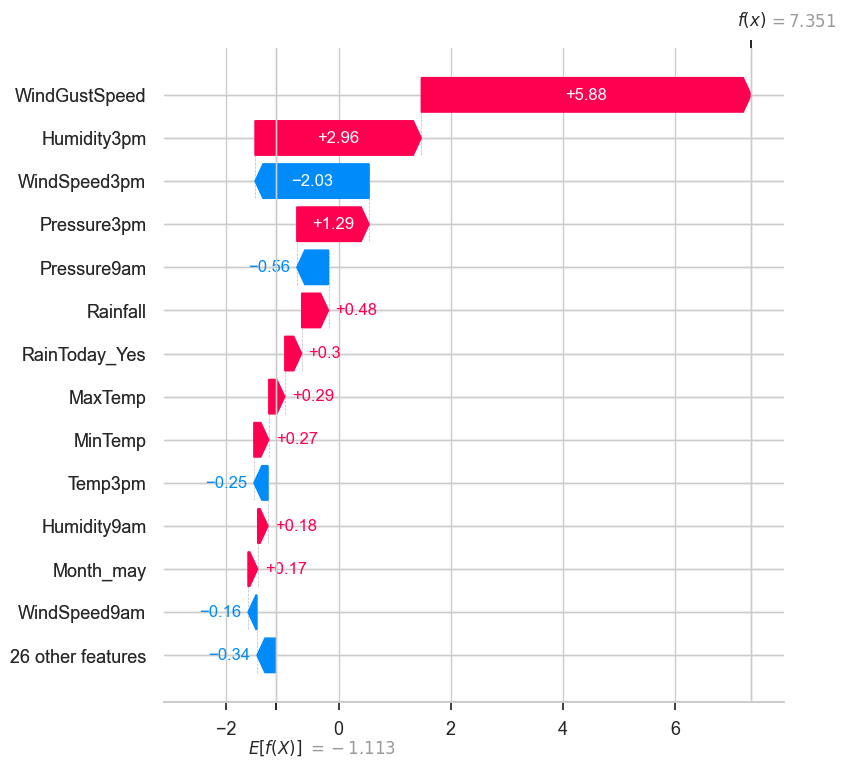

In [128]:
shap.plots.waterfall(explanation,max_display=14)

La velocidad de las ráfagas de viento de esta observación motiva a que su logaritmo de las chances aumente 5.88 con respecto al logaritmo de las chances esperado. Por el contario, la velocidad del viento de las 3 pm tiene el efecto de bajar 2.03 el logaritmo de las chaces de esta observación con respecto al valor esperado.

### Interpretabilidad **global**

In [129]:
explanation = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value,
    feature_names=features,
    data=array_x_test_clean
)

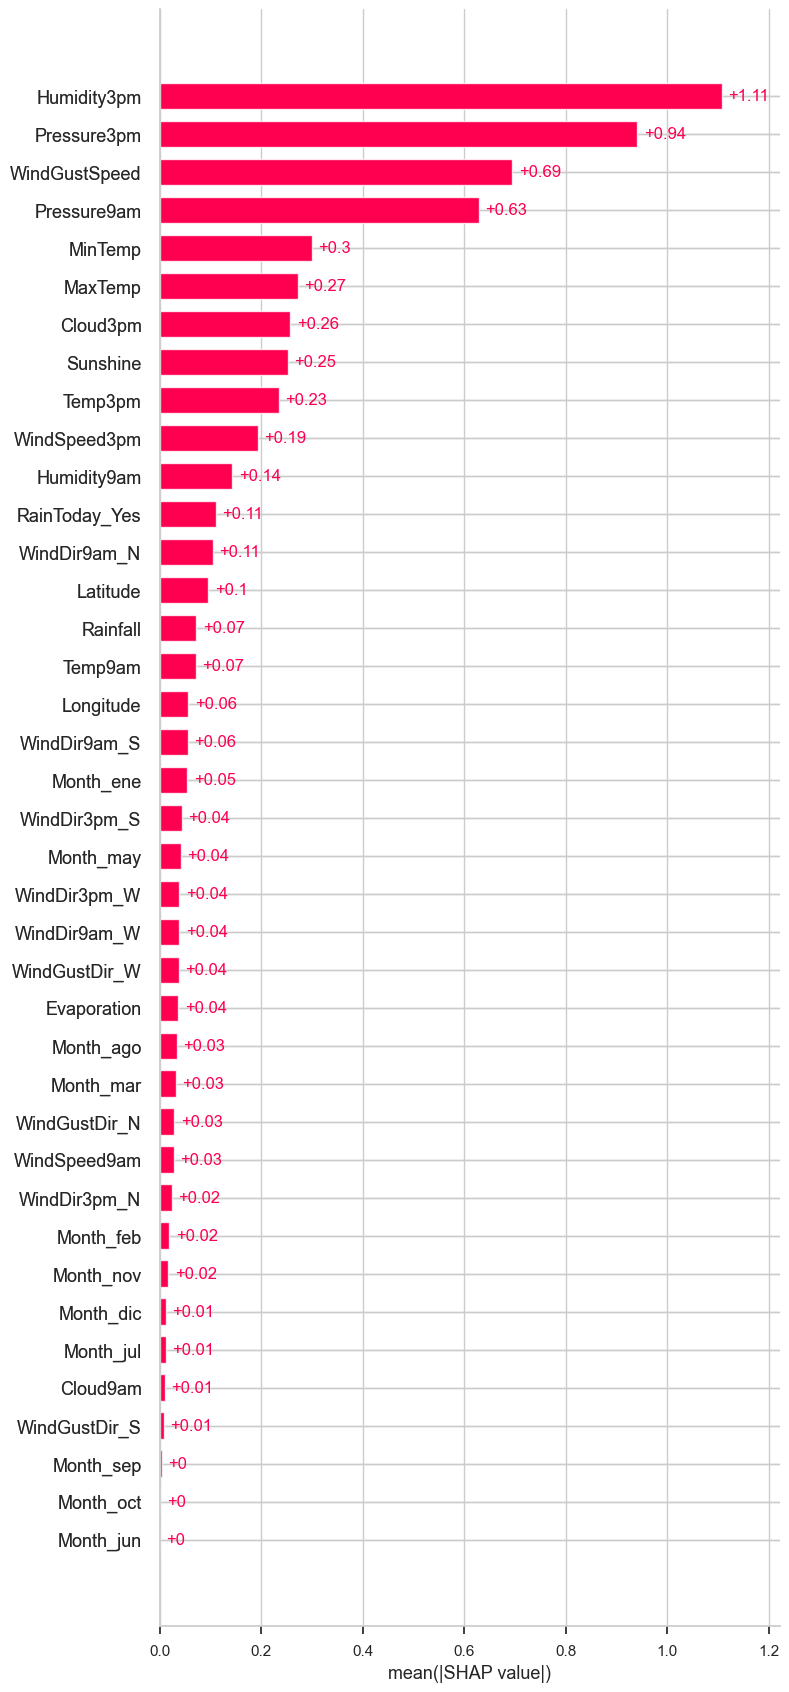

In [130]:
# Este gráfico es de difícil interpretación porque la explicabilidad de ciertas features cualitativas 
# está desagrupada en varias columnas dummies, por ende, se jusitifica realizar una reagrupación.
shap.plots.bar(explanation,max_display=len(features))

In [131]:
shap_values_abs = np.abs(shap_values)
shap_values_abs_mean_by_feature = np.mean(shap_values_abs,axis=0)
explicabilidad_s = pd.Series(shap_values_abs_mean_by_feature,index=features)
explicabilidad_s = round(explicabilidad_s.sort_values(ascending=False),2)
explicabilidad_s

Humidity3pm      1.11
Pressure3pm      0.94
WindGustSpeed    0.69
Pressure9am      0.63
MinTemp          0.30
MaxTemp          0.27
Cloud3pm         0.26
Sunshine         0.25
Temp3pm          0.23
WindSpeed3pm     0.19
Humidity9am      0.14
RainToday_Yes    0.11
WindDir9am_N     0.11
Latitude         0.10
Rainfall         0.07
Temp9am          0.07
Longitude        0.06
WindDir9am_S     0.06
Month_ene        0.05
WindDir3pm_S     0.04
Month_may        0.04
WindDir3pm_W     0.04
WindDir9am_W     0.04
WindGustDir_W    0.04
Evaporation      0.04
Month_ago        0.03
Month_mar        0.03
WindGustDir_N    0.03
WindSpeed9am     0.03
WindDir3pm_N     0.02
Month_feb        0.02
Month_nov        0.02
Month_dic        0.01
Month_jul        0.01
Cloud9am         0.01
WindGustDir_S    0.01
Month_sep        0.00
Month_oct        0.00
Month_jun        0.00
dtype: float64

In [132]:
def reasignacion(exp_features_con_dummies:pd.Series)->pd.Series:
    dict_map = {
        'Location' : [ 'Latitude','Longitude',],
        'Date' : [ 'Month_ago','Month_dic','Month_ene','Month_feb','Month_jul','Month_jun','Month_mar','Month_may','Month_nov','Month_oct','Month_sep'],
        'WindGustDir' : [ 'WindGustDir_N','WindGustDir_S','WindGustDir_W',],
        'WindDir9am' : [  'WindDir9am_N','WindDir9am_S','WindDir9am_W'],
        'WindDir3pm' : [ 'WindDir3pm_N','WindDir3pm_S','WindDir3pm_W',],
    }
    dummy_features = []
    for dummy_cols in dict_map.values():
        dummy_features += dummy_cols
    exp_features_sin_dummies = pd.Series() 
    for feature,shap_mean_abs_value in exp_features_con_dummies.items():
        if feature not in dummy_features:
            exp_features_sin_dummies[feature] = shap_mean_abs_value
    for feature_cuantitativa,dummies in dict_map.items():
        shap_mean_abs_value_acumulado = 0
        for dummy in dummies:
            shap_mean_abs_value_acumulado += exp_features_con_dummies[dummy]
        exp_features_sin_dummies[feature_cuantitativa] = shap_mean_abs_value_acumulado
    return exp_features_sin_dummies
explicabilidad_reasignada= reasignacion(explicabilidad_s)    
explicabilidad_reasignada = explicabilidad_reasignada.sort_values(ascending=False)

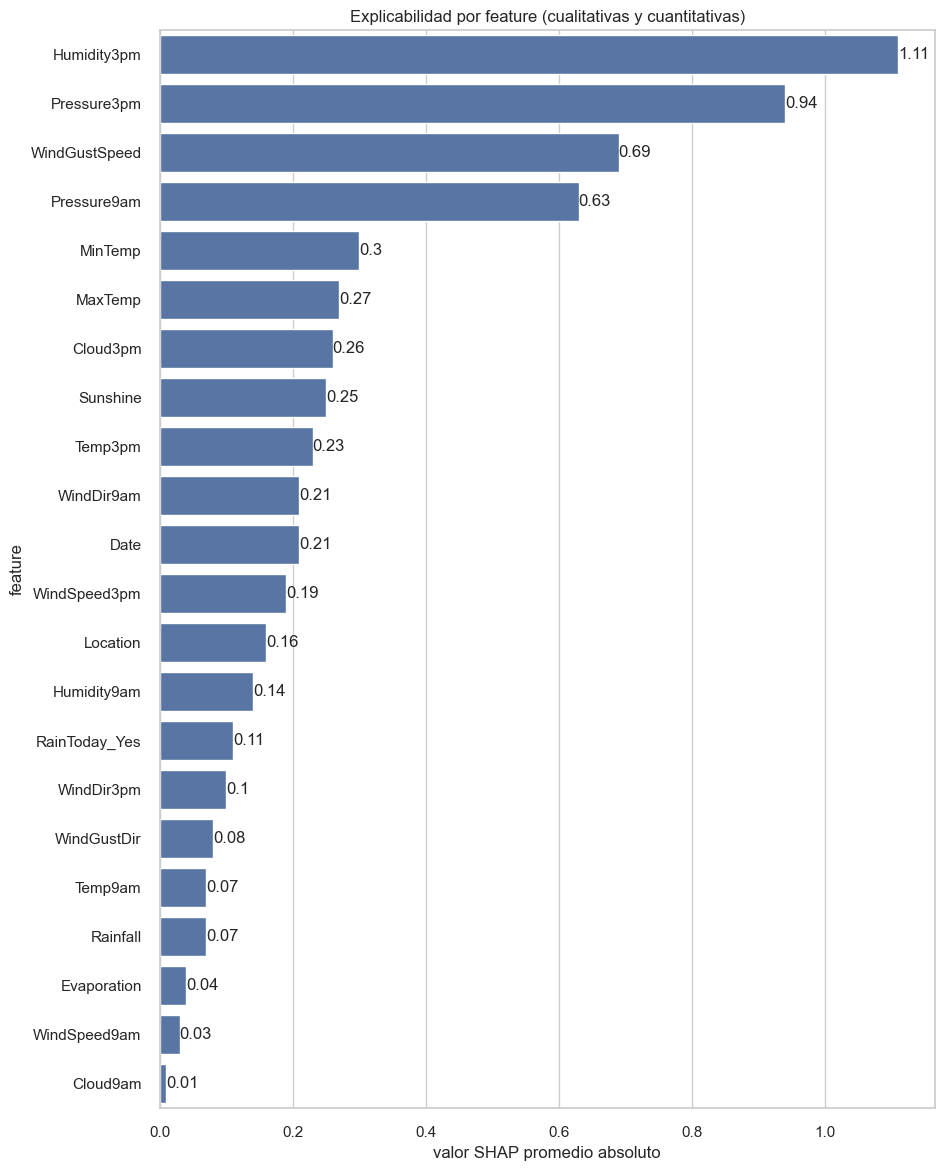

In [133]:
plt.figure(figsize=(10,14))
ax = sns.barplot(x=explicabilidad_reasignada.values,y=explicabilidad_reasignada.index)
plt.title('Explicabilidad por feature (cualitativas y cuantitativas)')
plt.ylabel('feature')
plt.xlabel('valor SHAP promedio absoluto')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

En base al valor SHAP promedio en valor absoluto de las features puede inferirse cuáles son las más importantes para predecir la probabilidad de que al día siguiente llueva, por lo cual, resulta factible afirmar que, en promedio, la humedad de las 3 pm, la velocidad de las ráfagas de viento y la presión de las 3 pm, en este orden, son las variables explicativas más importantes para predecir el valor de la target. Por el contrario, la nubosidad de las 9 am no es una variable relevante según el modelo para predecir si al día siguiente va a llover, motivo por el cual esta feature podría ser descartada del modelo. Como así también la velocidad del viento de las 9 am y la evaporación.

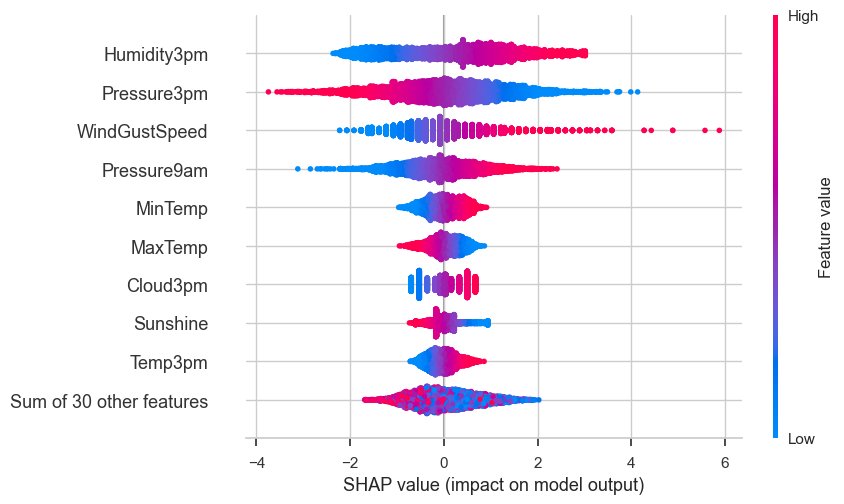

In [134]:
shap.plots.beeswarm(explanation)

Se observa una correlación positiva entre la humedad de las 3 pm y la probabilidad de que llueva al día siguiente, a mayores valores de humedad, mayores SHAP values (aumento del logaritmo de las chances). Por el contrario, la presión de las 3 pm muestra una correlación negativa con la target. En relación a la velocidad de las ráfagas de viento, se disntingue una gran dispersión que no obstante incluye valores SHAP atípicos.

## Punto 6 : Implementar Modelo de AUTO-ML con Pycaret

In [151]:
#Función para calculo de métrica Pondered_accuracy
def pondered_accuracy(y_true, y_pred, **kwargs):  # **kwargs, para que se pasen a la función cualquier cantidad de argumentos adicionales en forma de pares clave-valor.
    y_true = np.array(y_true)    # Verificar que los valores sean arrays de numpy para evitar problemas de comparación
    y_pred = np.array(y_pred)
    recall_scorer_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_scorer_1 = recall_score(y_true, y_pred, pos_label=1)
    return (2 * recall_scorer_1 + recall_scorer_0)/3

In [152]:
# Concatenar Datasets de Train y test completos
train_data_py = pd.concat([x_train_clean, y_train_clean], axis=1)
test_data_py = pd.concat([x_test_clean, y_test_clean], axis=1)

# Restablecer el índice para evitar duplicados
train_data_py = train_data_py.reset_index(drop=True)
test_data_py = test_data_py.reset_index(drop=True)

In [153]:
# Ejecutar setup() para preparar el entorno de PyCaret.
clf_py = setup(data=train_data_py, target='RainTomorrow_Yes', session_id=123, test_data=test_data_py, index=False, fix_imbalance=True)

In [154]:
# Definimos metrica personalizada con la funcion pondered_accuracy
add_metric('pondered_accuracy_metric', 'Pondered Accuracy Metric', pondered_accuracy, greater_is_better=True)

Name                                          Pondered Accuracy Metric
Display Name                                  Pondered Accuracy Metric
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(pondered_accuracy, response_method...
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: pondered_accuracy_metric, dtype: object

In [155]:
# Usamos compare_models() para realizar la comparación de modelos y obtener un DataFrame con los resultados.
best_model = compare_models()

In [156]:
best_model


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Se obtiene como mejor modelo: LGBMCClassifier
* LGBMClassifier (LightGBM): LightGBM es una implementación optimizada de "GBDT" (boosting "Gradient Boosting Decision Tree", método iterativo que construye árboles secuenciales, optimizando el error residual de cada etapa)
* LGBMClassifier aplica la misma idea de GBDT (boosting con árboles de decisión) pero con optimizaciones específicas para mejorar velocidad y eficiencia en grandes conjuntos de datos.
* GBDT (Gradient Boosting Decision Trees): Es una técnica de boosting que combina múltiples árboles de decisión secuenciales, donde cada árbol intenta corregir los errores del anterior. Al sumar estos árboles, el modelo final es una combinación de los predictores.

In [157]:
# Verifica los gráficos disponibles para el modelo actual
available_plots = get_config('_available_plots')
print(available_plots)

{'pipeline': 'Pipeline Plot', 'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

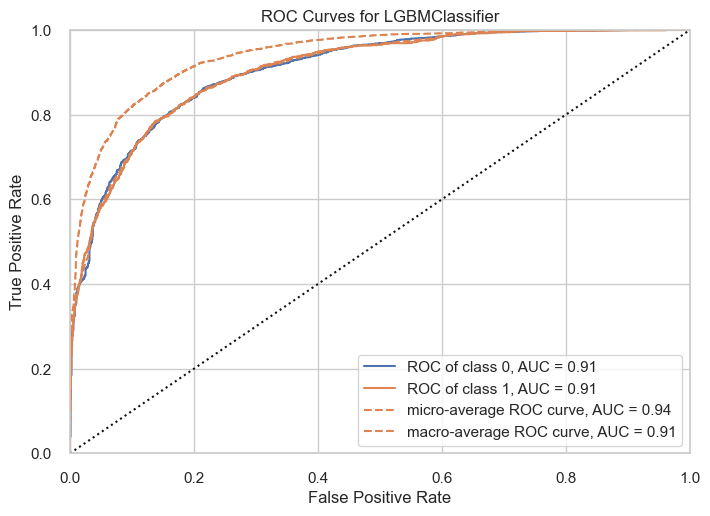

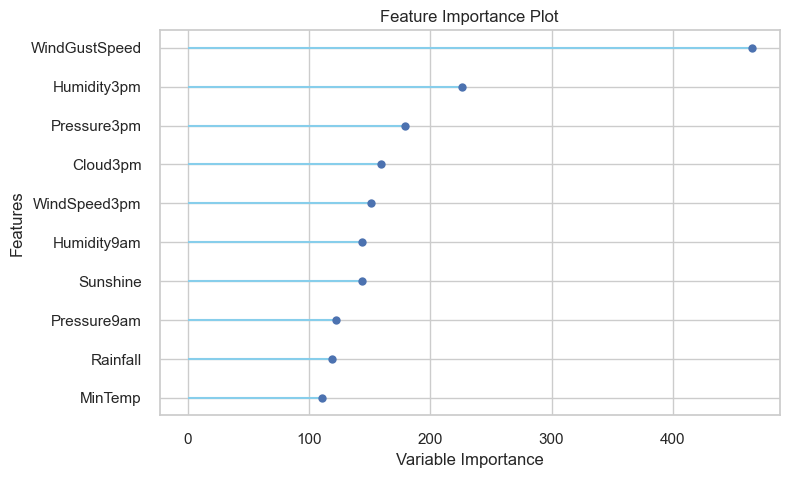

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


       MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     0.718165  1.262832 -0.322107     1.211113  1.007699       0.833085   
1     0.843394  0.139664  0.554187     0.238936  0.320968      -1.529343   
2     1.375616  0.398857  1.292119     0.416342 -2.365392       1.592437   
3    -1.238535 -0.335522 -0.414349    -0.199126 -0.002231      -0.769991   
4    -0.753273  1.205233 -0.414349    -0.378428  0.147216      -0.095011   
...        ...       ...       ...          ...       ...            ...   
5642 -0.205397  1.147635 -0.414349     1.211113  1.248634      -0.601246   
5643 -0.972424  0.643650 -0.414349     0.787235  1.179795      -0.263756   
5644 -0.252358 -0.277924 -0.414349    -0.537382  0.388151       0.073733   
5645  1.313001  2.486796 -0.414349    -0.669885 -0.464016      -0.769991   
5646 -0.518469 -1.228296 -0.414349    -0.582480 -0.153470       3.448631   

      WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Month_jul  \
0        

In [159]:
# Evaluar el mejor modelo con otras métricas disponibles en evaluate_model.
evaluate_model(best_model)

# Verificar si el modelo best_model es de clasificación, antes de intentar generar una curva ROC, asegurándose de que el modelo sea compatible con esta evaluación
if 'Classifier' in str(type(best_model)):      # verifica si best_model es un clasificador, revisando si el tipo de modelo contiene la palabra "Classifier". Si es de clasificación, genera la curva ROC
    # Generar la curva ROC solo si el modelo es un clasificador
    plot_model(best_model, plot='auc')
else:
    print("El modelo no es de clasificación. No se puede generar la curva ROC.")

# Mostrar la importancia de las características
plot_model(best_model, plot='feature')

# Guardar el modelo para usarlo en producción
save_model(best_model, 'best_model_AUTOML')

# Cargar el modelo guardado, para verificar su funcionamiento.
loaded_model = load_model('best_model_AUTOML')

# Hacer predicciones en el conjunto de test con el modelo cargado
predictions = predict_model(loaded_model, data=test_data_py)
print(predictions)

Conclusión AUTOML PYCARET vs Reg. Log.

El modelo que AUTOML PyCaret determina como mejor modelo para los datos brindados, es un clasificador LGBMClassifier, ya que es el que mejor métricas tiene en general, no obstante, evaluando la métrica Pondered Accuracy Metric (media ponderada del recall de ambas clases - lluvia y no lluvia), dicho modelo presenta un rendimiento inferior ( 0.7503) al modelo de regresión logística obtenido con GridSearch (Pondered accuracy en test: 0.8101).

La importancia de las características es diferente entre el modelo de AUTOML PyCaret (LGBMClassifier) y la regresión logística. Si bien las 3 caract. principales son iguales, cambia el orden de importancia , siendo WindGustSpeed (velocidad de las ráfagas de viento) para LGBMClassifier la característica que más aporta a la predicción, seguida de la humedad de las 3 pm y la presión de las 3 pm. 

**Reg Log con AutoMl vs Reg Log con optimizacion de Hiperparámetros:**

Si analizamos la métrica Pondered_acuracy obtenida en Logistic Regression de AutoMl con Pycaret (0.8050) en relacion a la métrica obtenida con Optimización de hiperparámetros de nuestro modelo (0.8101), notamos que también es más robusto este uúiltimo modelo.  

#### CALCULO FUNCION DE PERDIDA (Binary Cross Entropy/Log Loss for Binary Classification)

In [ ]:
"""# # Construyo el modelo que reporta la mejor métrica   FACU SHARP
# model = LogisticRegression(C= 1, class_weight= 'balanced', max_iter= 10, penalty= 'l2', solver= 'lbfgs',random_state=42)
# model.fit(x_train_clean,y_train_clean)
# y_pred = model.predict(x_test_clean)

# Cambio el tipo de dato a array para evitar problemas con los métodos de sharp
array_x_train_clean = np.array(x_train_clean)
array_x_test_clean = np.array(x_test_clean)
features = x_train_clean.columns

y_pred = best_grid_model.predict_proba(array_x_test_clean)

---------------------------------------------------------------------------
                                                    
# Obtener el mejor modelo y sus hiperparámetros
# best_grid_model = LogisticRegression(**best_grid_params, random_state=42)
# best_grid_model.fit(x_train_clean, y_train_clean)
# Cargar el modelo guardado
best_grid_model = joblib.load('best_grid_model.joblib')

# Cargar los mejores parámetros desde el archivo JSON
with open('best_grid_params.json', 'r') as archivo:
    best_grid_params = json.load(archivo)

with open('best_grid_score.json', 'r') as archivo:
    best_grid_score = json.load(archivo)

print("Modelo y parámetros cargados exitosamente.")

# Calcular las métricas en el conjunto de prueba
y_pred_grid = best_grid_model.predict(x_test_clean)
test_pondered_accuracy_grid = pondered_accuracy(y_test_clean, y_pred_grid)

print(f"Mejores parámetros del grid: {best_grid_params}")
print(f"Pondered accuracy en train: {best_grid_score}")
print(f"Pondered accuracy en test: {test_pondered_accuracy_grid}")
"""

In [158]:
array_x_train_clean = np.array(x_train_clean)
array_x_test_clean = np.array(x_test_clean)
features = x_train_clean.columns
y_pred_grid = best_grid_model.predict(x_test_clean)
y_pred_proba = best_grid_model.predict_proba(array_x_test_clean)

In [168]:
# FUNCION DE PERFIDA DE REGRESION LOGISTICA

# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Función de pérdida (log-loss) para regresión logística
def log_loss(y_true, y_pred):
    n = len(y_true)  # Número de ejemplos
    # Aseguramos que las predicciones estén en el rango [eps, 1 - eps] para evitar log(0)
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    # Calculamos la log-loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


# Obtener los parámetros (coeficientes) del modelo
theta = best_grid_model.coef_.flatten()  # Obtener los coeficientes y hacerlos un vector 1D

# Obtener el término de intersección (bias o intercept)
intercept = best_grid_model.intercept_

print(f'Los parámetros theta (coeficientes) son: {theta}')
print(f'El término de intersección (bias) es: {intercept}')

# Hacemos las predicciones utilizando la función sigmoide
#z = np.dot(x_test_clean, theta)  # Producto punto entre X y theta
#y_pred = sigmoid(z)  # Predicciones con la función sigmoide

# Calculamos la función de pérdida
loss = log_loss(y_test_clean, y_pred_grid)

print(f'La función de pérdida (log-loss) es: {loss}')

Los parámetros theta (coeficientes) son: [ 3.56125652e-01 -3.27322488e-01  1.22021872e-01 -4.97041979e-02
 -3.39726937e-01  9.06033902e-01 -3.56734183e-02 -2.46456957e-01
  1.71234017e-01  1.24959279e+00  8.04642632e-01 -1.21006494e+00
  1.39694560e-02  3.58415815e-01 -8.40305894e-02  2.84655360e-01
 -1.22412854e-01 -6.97085548e-02  7.31009899e-02  1.80668386e-02
  1.45948158e-01  2.35803660e-01  1.27973115e-01  1.80516594e-01
  5.94899156e-02 -9.28008115e-02  1.18290440e-01  3.57597196e-01
  2.24880712e-01 -8.90738821e-02 -3.79241425e-01 -1.73143150e-01
  7.35624600e-02  6.72130418e-04 -1.62536213e-01  2.01757612e-01
 -1.20702287e-01  5.51317133e-03 -3.10676045e-02]
El término de intersección (bias) es: [-1.04186316]
La función de pérdida (log-loss) es: 6.6974751565495225


In [169]:
# Example true labels and predicted probabilities (etiquetas verdaderas y probabilidades predichas)
y_true = y_test_clean
y_pred = y_pred_proba

# Asegúrate de que y_true y y_pred tengan el tipo correcto (float32)
y_true = tf.cast(y_true, tf.float32)
y_pred = tf.cast(y_pred, tf.float32)


In [ ]:
# Al calcular el logaritmo de valores cercanos a 0 o 1 (que pueden ser exactamente 0 o 1 debido a la precisión numérica), se generan valores indefinidos o infinitos, lo que da como resultado NaN. 
# Al "clipear" los valores de predicción, evitamos estos problemas y hacemos que el cálculo de la entropía cruzada sea numéricamente estable.
# Asegurar que las predicciones no sean exactamente 0 o 1
#y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

# Aseguramos que las predicciones estén en el rango [eps, 1 - eps] para evitar log(0)
eps = 1e-15
y_pred_clip = np.clip(y_pred, eps, 1 - eps)

# Verifica el rango de las predicciones después de hacer el clip
print(f"Predicciones después de clip (y_pred): {y_pred[:10]}")  # Muestra las primeras 10 predicciones recortadas

# Compute Binary Cross-Entropy using NumPy
def binary_cross_entropy(y_true, y_pred):
    bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return bce

bce_loss = binary_cross_entropy(y_true, y_pred)  # Convierto a numpy arrays para el cálculo
print(f"Binary Cross-Entropy Loss (manual calculation): {bce_loss}")

# Compute Binary Cross-Entropy using Keras
bce_loss_keras = binary_crossentropy(y_true, y_pred).numpy()
print(f"Binary Cross-Entropy Loss (Keras): {bce_loss_keras}")

## Punto 7 : Red Neuronal

In [286]:
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.regularizers import l1,  l2
from sklearn.utils.class_weight import compute_class_weight

In [107]:
# # esto es para usar GPU en caso de tenerla disponible
# device = "cpu"
# if torch.cuda.is_available():
#   device = "cuda:0"

# device

In [287]:
# Verificar si hay GPU disponible
if tf.config.list_physical_devices('GPU'):
    device = "/GPU:0"  # Usar la primera GPU disponible
else:
    device = "/CPU:0"  # Usar CPU si no hay GPU

device

'/CPU:0'

In [128]:
# Dimensiones de X_train_clean: (22253, 39)
# Dimensiones de y_train_clean: (22253,)
# Dimensiones de X_test_clean: (5647, 39)
# Dimensiones de y_test_clean: (5647,)

In [288]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

### prueba 1
Básico sin validación

In [ ]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema. 
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self, learning_rate=0.01, epochs=500):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar 
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression() 
            en el caso de la regresión lineal.
        """
        model = Sequential([
            Dense(2, activation='sigmoid', input_shape=(39,)),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=SGD(learning_rate=self.learning_rate), loss='mse')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
        print(model.summary())
    
    def fit(self, X, y):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [179]:
nn_tensorflow = NeuralNetworkTensorFlow(learning_rate=0.1, epochs=1000)
loss_history = nn_tensorflow.fit(X_train_rn, y_train_rn)

n° de parámetros: 83


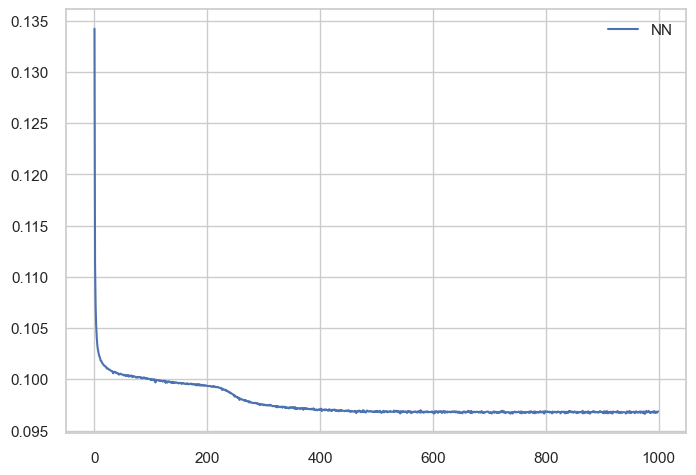

In [180]:
plt.plot(loss_history, label='NN')
# plt.axhline(mse_linear_model, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

In [165]:
loss_history[-1]

0.09674684703350067

In [166]:
predictions = nn_tensorflow.predict(X_train_rn)
print("Predicciones:", predictions)
predictions.shape

557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step
Predicciones: [[0.33875   ]
 [0.00654158]
 [0.00844553]
 ...
 [0.05602047]
 [0.09647529]
 [0.6816381 ]]


(17802, 1)

In [116]:
predictions = nn_tensorflow.predict(x_test_clean)
print("Predicciones:", predictions)
predictions.shape

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
Predicciones: [[0.15651144]
 [0.3224004 ]
 [0.9364966 ]
 ...
 [0.05087852]
 [0.00141312]
 [0.8123474 ]]


(5647, 1)

### pruebas con conjunto de validación


In [117]:
X_train_rn.shape, X_valid_rn.shape

((17802, 39), (4451, 39))

In [289]:
# Métrica pondered_accuracy

def pondered_accuracy(y_true, y_pred):
    # Convertimos predicciones a clases binarias (umbral 0.5)
    y_pred_binary = tf.cast(y_pred > 0.34, tf.int32) #0.5
    y_true = tf.cast(y_true, tf.int32)
    # Calculamos recall por clase
    recall_0 = tf.reduce_sum(tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (tf.reduce_sum(tf.cast(y_true == 0, tf.float32) + tf.keras.backend.epsilon()))
    recall_1 = tf.reduce_sum(tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (tf.reduce_sum(tf.cast(y_true == 1, tf.float32) + tf.keras.backend.epsilon()))
    # Ponderación
    return (2 * recall_1 + recall_0) / 3



Cuando utilizas class_weight='balanced' (o calculas manualmente los pesos con una fórmula proporcional), la clase con menos datos recibe más peso. Esto significa que en tu caso:

Clase 1 (llueve): Recibirá más peso porque tiene menos muestras.

Clase 0 (no llueve): Recibirá menos peso porque tiene más muestras.

El objetivo de class_weight es equilibrar el impacto de cada clase en la función de pérdida durante el entrenamiento. 

Si una clase tiene pocas muestras, sus errores contribuirán menos al cálculo de la pérdida total. 

Darle un peso mayor asegura que sus errores sean tan importantes como los de la clase mayoritaria.

In [290]:
# Balanceo

num_classes = len(np.unique(y_train_rn))
print(num_classes)
# Calcular los pesos de las clases
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_rn), y=y_train_rn)
print(class_weights)
# Convertir a un diccionario
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}
print("Pesos de las clases:", class_weight_dict)


2
[0.64425304 2.23306573]
Pesos de las clases: {0: 0.6442530399536769, 1: 2.233065730055193}


la clase minoritaria le da mas importancia y le aplica un alfo factor de balanceo 2.233 VERRRRRRRRRR


#### Básico con validación

In [120]:
# básico con accuracy
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape, num_classes):
        # ejemplo con 2 capas ocultas de 64 neuronas y activación softmax (multiclase, recibe la cantidad de clases como input, además del input_shape)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(input_shape,)),
            # tf.keras.layers.Dense(8, activation=LeakyReLU(alpha=0.1)),
            tf.keras.layers.Dropout(rate=0.2, seed=42),
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

        #compilo el modelo con el optimizador Adam, 
        # la función de pérdida binary_crossentropy porque son 2 clases
        # la métrica accuracy (cambiar por pondered accuracy)
        #totalmente optimizable e incluso pueden ser parámetros de la función build_model

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Agregamos nuestra métrica personalizada

        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train,
                            y_train,
                            validation_data=(X_valid, y_valid),
                            epochs=self.epochs,
                            batch_size=self.batch_size,
                            )
        return history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']


    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"test accuracy: {accuracy:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions

#### Personalizado con validación

pondered_accurary

balanceo

In [121]:
# personalizado
class NeuralNetwork_p:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape, num_classes):
        # ejemplo con 2 capas ocultas de 64 neuronas y activación softmax (multiclase, recibe la cantidad de clases como input, además del input_shape)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(input_shape,), kernel_regularizer=l1(0.1)),
            # tf.keras.layers.Dense(8, activation=LeakyReLU(alpha=0.1)),
            tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=l1(0.1))
        ])

        #compilo el modelo con el optimizador Adam, 
        # la función de pérdida binary_crossentropy porque son 2 clases
        # la métrica accuracy (cambiar por pondered accuracy)
        #totalmente optimizable e incluso pueden ser parámetros de la función build_model

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[pondered_accuracy])  # Agregamos nuestra métrica personalizada

        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train,
                            y_train,
                            validation_data=(X_valid, y_valid),
                            epochs=self.epochs,
                            batch_size=self.batch_size,
                            class_weight=class_weight_dict  # Aquí pasamos los pesos calculados
                            )
        return history.history['loss'], history.history['val_loss'], history.history['pondered_accuracy'], history.history['val_pondered_accuracy']


    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"test accuracy: {accuracy:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions
    

    ### acá también me podría armar una función para graficar la evolución de la función de pérdida en train y validación, etc etc

In [122]:

nn = NeuralNetwork(epochs=100, batch_size=128, learning_rate=0.01)#0.01 0.05

#buildeo el modelo
nn.build_model(input_shape=X_train_rn.shape[1], num_classes=1)

# entreno el modelo
history = nn.train(X_train_rn, y_train_rn, X_valid_rn, y_valid_rn)

# evaluo metricas
# nn.evaluate(x_test_clean, y_test_clean)

## predicciones...

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7707 - loss: 0.4777 - val_accuracy: 0.7697 - val_loss: 0.3809
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.4020 - val_accuracy: 0.8492 - val_loss: 0.3663
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8235 - loss: 0.3948 - val_accuracy: 0.8522 - val_loss: 0.3607
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.3860 - val_accuracy: 0.8598 - val_loss: 0.3571
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.3850 - val_accuracy: 0.8569 - val_loss: 0.3566
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8299 - loss: 0.3824 - val_accuracy: 0.8598 - val_loss: 0.3564
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.3867 - val_accuracy: 0.8587 - val_loss: 0.3590
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.3804 - val_accu

In [123]:
y_test_clean

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [124]:
# evaluo metricas
nn.evaluate(x_test_clean, y_test_clean)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.8532 - loss: 0.3415
test accuracy: 0.8551


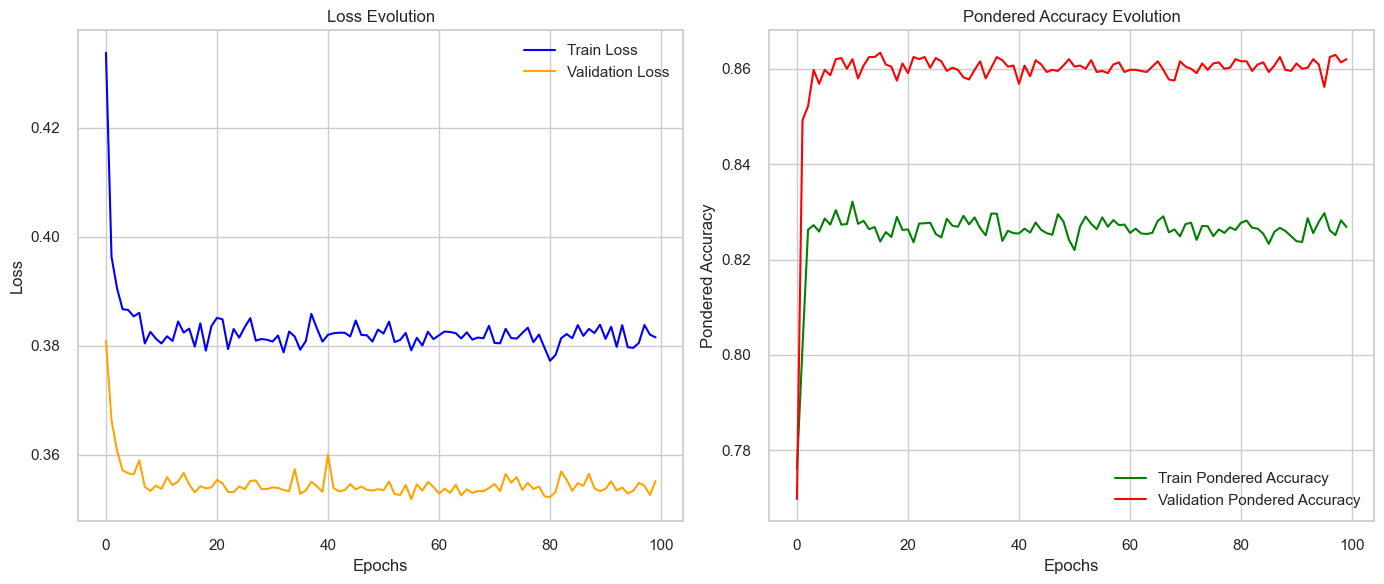

In [135]:

# Obtener el historial del entrenamiento
loss_train = history[0]  # Pérdida en entrenamiento
loss_val = history[1]  # Pérdida en validación
accuracy_train = history[2]  # Métrica ponderada en entrenamiento
accuracy_val = history[3]  # Métrica ponderada en validación

# Crear la figura
plt.figure(figsize=(14, 6))

# Gráfico de la función de pérdida
plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train Loss', color='blue')
plt.plot(loss_val, label='Validation Loss', color='orange')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de pondered_accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label='Train Pondered Accuracy', color='green')
plt.plot(accuracy_val, label='Validation Pondered Accuracy', color='red')
plt.title('Pondered Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Pondered Accuracy')
plt.legend()
plt.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


### prueba 3

In [291]:

X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir la métrica personalizada
def pondered_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.28, tf.int32)  # Umbral 0.5
    y_true = tf.cast(y_true, tf.int32)

    recall_0 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 0, tf.float32)) + tf.keras.backend.epsilon())
    
    recall_1 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 1, tf.float32)) + tf.keras.backend.epsilon())

    return (2 * recall_1 + recall_0) / 3

# Crear el modelo
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Una salida para clasificación binaria
# ])

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Una salida para clasificación binaria
# ])

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Una salida para clasificación binaria
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Una salida para clasificación binaria
])


# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[pondered_accuracy])

# Entrenar el modelo
history = model.fit(X_train_rn, y_train_rn,
                    validation_data=(X_valid_rn, y_valid_rn),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,  # Manejar desbalance
                    verbose=1)

# Evaluar el modelo
loss, pondered_acc = model.evaluate(X_valid_rn, y_valid_rn, verbose=0)
print(f"Validation Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")


KeyError: 3

In [136]:
# Evaluar el modelo
loss, pondered_acc = model.evaluate(x_test_clean, y_test_clean, verbose=0)
print(f"Test Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")

Test Loss: 1.8003, Pondered Accuracy: 0.6667


In [137]:
# Extraer datos del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_pondered_acc = history.history['pondered_accuracy']
val_pondered_acc = history.history['val_pondered_accuracy']

# Configurar las épocas
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graficar la métrica personalizada
plt.subplot(1, 2, 2)
plt.plot(epochs, train_pondered_acc, label='Training Pondered Accuracy', marker='o')
plt.plot(epochs, val_pondered_acc, label='Validation Pondered Accuracy', marker='o')
plt.title('Pondered Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pondered Accuracy')
plt.legend()
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()


AttributeError: 'tuple' object has no attribute 'history'

In [ ]:
# Realizar las predicciones (probabilidades)
y_pred_prob = model.predict(x_test_clean)

# Convertir a predicciones binarias usando un umbral (por defecto, 0.5)
y_pred_binary = (y_pred_prob > 0.28).astype(int)

# Mostrar las probabilidades y las predicciones
print("Predicciones (probabilidades):", y_pred_prob[:10].flatten())  # Mostrar primeras 10 probabilidades
print("Predicciones (binarias):", y_pred_binary[:10].flatten())      # Mostrar primeras 10 predicciones


177/177 [==============================] - 0s 684us/step
Predicciones (probabilidades): [0.42932382 0.39024115 0.9487887  0.07232568 0.18631946 0.60656416
 0.22344948 0.77636826 0.0998022  0.43952316]
Predicciones (binarias): [1 1 1 0 0 1 0 1 0 1]


In [138]:
# Crear un DataFrame con los valores reales y predichos
results_df = pd.DataFrame({
    "Actual": y_test_clean,  # Valores reales
    "Predicted": y_pred_binary.flatten()  # Valores predichos
})

# Mostrar las primeras filas del DataFrame
print(results_df)


NameError: name 'y_pred_binary' is not defined

In [ ]:
type(y_test_clean)
y_test_clean
len(y_test_clean)

5647

In [ ]:
# Filtrar casos en los que el modelo se equivocó
errors = results_df[results_df["Actual"] != results_df["Predicted"]]
print(errors)


      Actual  Predicted
0          0          1
1          0          1
5          0          1
7          0          1
9          0          1
...      ...        ...
5633       1          0
5637       0          1
5638       0          1
5639       0          1
5640       0          1

[1686 rows x 2 columns]


In [ ]:
from sklearn.metrics import classification_report

# Generar un informe detallado
print("Classification Report:\n", classification_report(y_test_clean, y_pred_binary))
print("Classification Report:\n", confusion_matrix(y_test_clean, y_pred_binary))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.64      0.77      4373
           1       0.42      0.92      0.58      1274

    accuracy                           0.70      5647
   macro avg       0.69      0.78      0.67      5647
weighted avg       0.84      0.70      0.73      5647

Classification Report:
 [[2794 1579]
 [ 107 1167]]


In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test_clean, y_pred_binary).ravel()

print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")


True Negatives (TN): 2583
False Positives (FP): 1790
False Negatives (FN): 81
True Positives (TP): 1193


In [ ]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir la métrica personalizada
def pondered_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.28, tf.int32)  # Umbral 0.5
    y_true = tf.cast(y_true, tf.int32)

    recall_0 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 0, tf.float32)) + tf.keras.backend.epsilon())
    
    recall_1 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 1, tf.float32)) + tf.keras.backend.epsilon())

    return (2 * recall_1 + recall_0) / 3

# Crear el modelo

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Una salida para clasificación binaria
])


# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[pondered_accuracy])

# Entrenar el modelo
history = model.fit(X_train_rn, y_train_rn,
                    validation_data=(X_valid_rn, y_valid_rn),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,  # Manejar desbalance
                    verbose=1)

# Evaluar el modelo
loss, pondered_acc = model.evaluate(X_valid_rn, y_valid_rn, verbose=0)
print(f"Validation Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")

#### Optuna

In [ ]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir la métrica personalizada
def pondered_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.34, tf.int32)  # Umbral 0.5
    y_true = tf.cast(y_true, tf.int32)

    recall_0 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 0, tf.float32)) + tf.keras.backend.epsilon())
    
    recall_1 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 1, tf.float32)) + tf.keras.backend.epsilon())

    return (2 * recall_1 + recall_0) / 3

In [ ]:
# import optuna
# from tensorflow.keras.optimizers import Adam
# from sklearn.utils.class_weight import compute_class_weight

# Función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    num_units1 = trial.suggest_int('num_units1', 4, 64)  # Neuronas de la primera capa
    num_units2 = trial.suggest_int('num_units2', 2, 64)  # Neuronas de la segunda capa
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Tasa de Dropout
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # Tasa de aprendizaje
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)  # Tasa de aprendizaje
    # l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-2)  # Regularización L2
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-3, 1e+2)  # Regularización L2

    # Construir el modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(num_units1, activation='relu', input_shape=(X_train_rn.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units2, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[pondered_accuracy])

    # Ajustar el modelo
    history = model.fit(
        X_train_rn, y_train_rn,
        validation_data=(X_valid_rn, y_valid_rn),
        epochs=20,
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=0  # No mostrar logs de entrenamiento
    )

    # Evaluar el modelo
    val_accuracy = max(history.history['val_pondered_accuracy'])  # Mejor accuracy ponderado en validación
    return val_accuracy

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')  # Maximizar pondered_accuracy
study.optimize(objective, n_trials=50)  # Realizar 50 pruebas

# Mostrar los mejores hiperparámetros encontrados
print("Best hyperparameters:", study.best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
final_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(best_params['num_units1'], activation='relu', input_shape=(X_train_rn.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(best_params['num_units2'], activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                    loss='binary_crossentropy',
                    metrics=[pondered_accuracy])

# Entrenamiento final
final_model.fit(
    X_train_rn, y_train_rn,
    validation_data=(X_valid_rn, y_valid_rn),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)


In [ ]:
# Función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    num_units1 = trial.suggest_int('num_units1', 4, 64)  # Neuronas de la primera capa
    num_units2 = trial.suggest_int('num_units2', 2, 64)  # Neuronas de la segunda capa
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Tasa de Dropout
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)  # Tasa de aprendizaje
    l1_reg = trial.suggest_loguniform('l1_reg', 1e-3, 1e+2)  # Regularización L1

    # Construir el modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(num_units1, activation='relu', input_shape=(X_train_rn.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),  # Cambiado a L1
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units2, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),  # Cambiado a L1
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[pondered_accuracy])

    # Ajustar el modelo
    history = model.fit(
        X_train_rn, y_train_rn,
        validation_data=(X_valid_rn, y_valid_rn),
        epochs=20,
        batch_size=32,
        class_weight=class_weight_dict,
        verbose=0  # No mostrar logs de entrenamiento
    )

    # Evaluar el modelo
    val_accuracy = max(history.history['val_pondered_accuracy'])  # Mejor accuracy ponderado en validación
    return val_accuracy

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')  # Maximizar pondered_accuracy
study.optimize(objective, n_trials=50)  # Realizar 50 pruebas

# Mostrar los mejores hiperparámetros encontrados
print("Best hyperparameters:", study.best_params)


[I 2024-11-25 12:42:15,238] A new study created in memory with name: no-name-eec01312-423e-476c-8bfc-255eac9b6f63
[I 2024-11-25 12:42:48,793] Trial 0 finished with value: 0.6619043350219727 and parameters: {'num_units1': 26, 'num_units2': 34, 'dropout_rate': 0.3555557990458962, 'learning_rate': 0.38705070332009295, 'l1_reg': 25.394254021929115}. Best is trial 0 with value: 0.6619043350219727.
[I 2024-11-25 12:43:18,147] Trial 1 finished with value: 0.6619043350219727 and parameters: {'num_units1': 35, 'num_units2': 26, 'dropout_rate': 0.176447192008088, 'learning_rate': 0.1531458079736993, 'l1_reg': 40.47818199921136}. Best is trial 0 with value: 0.6619043350219727.
[I 2024-11-25 12:43:48,410] Trial 2 finished with value: 0.6619043350219727 and parameters: {'num_units1': 60, 'num_units2': 25, 'dropout_rate': 0.22211583026827997, 'learning_rate': 0.2646354965796028, 'l1_reg': 0.0052319746673566234}. Best is trial 0 with value: 0.6619043350219727.
[I 2024-11-25 12:44:18,442] Trial 3 fini

Best hyperparameters: {'num_units1': 26, 'num_units2': 34, 'dropout_rate': 0.3555557990458962, 'learning_rate': 0.38705070332009295, 'l1_reg': 25.394254021929115}


In [ ]:
# agrega epochs y batch-size a los parámetros
# tf.keras.layers.Dense(8, activation=LeakyReLU(alpha=0.1)),

def objective(trial):
    # Hiperparámetros a optimizar
    num_units1 = trial.suggest_int('num_units1', 4, 64)  # Neuronas de la primera capa
    num_units2 = trial.suggest_int('num_units2', 2, 64)  # Neuronas de la segunda capa
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Tasa de Dropout
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)  # Tasa de aprendizaje
    l1_reg = trial.suggest_loguniform('l1_reg', 1e-5, 1e+2)  # Regularización L1
    epochs = trial.suggest_int('epochs', 10, 500)  # Número de épocas
    batch_size = trial.suggest_int('batch_size', 16, 128)  # Tamaño de batch

    # Construir el modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(num_units1, activation=LeakyReLU(alpha=0.1), input_shape=(X_train_rn.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units2, activation=LeakyReLU(alpha=0.1),
                              kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[pondered_accuracy])

    # Ajustar el modelo
    history = model.fit(
        X_train_rn, y_train_rn,
        validation_data=(X_valid_rn, y_valid_rn),
        epochs=epochs,  # Optimizamos las épocas
        batch_size=batch_size,  # Optimizamos el tamaño del batch
        class_weight=class_weight_dict,
        verbose=0
    )

    # Evaluar el modelo
    val_accuracy = max(history.history['val_pondered_accuracy'])  # Mejor accuracy ponderado en validación
    return val_accuracy

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')  # Maximizar pondered_accuracy
study.optimize(objective, n_trials=50)  # Realizar 50 pruebas

# Mostrar los mejores hiperparámetros encontrados
print("Best hyperparameters:", study.best_params)


[I 2024-11-25 23:00:04,678] A new study created in memory with name: no-name-d21346cb-fc2e-4cf0-bc50-8053e91be5c0


[I 2024-11-25 23:05:34,021] Trial 0 finished with value: 0.6668549180030823 and parameters: {'num_units1': 20, 'num_units2': 48, 'dropout_rate': 0.35516082568345064, 'learning_rate': 0.3943010496411322, 'l1_reg': 0.49198257002642115, 'epochs': 471, 'batch_size': 68}. Best is trial 0 with value: 0.6668549180030823.
[I 2024-11-25 23:09:01,345] Trial 1 finished with value: 0.825840413570404 and parameters: {'num_units1': 15, 'num_units2': 58, 'dropout_rate': 0.12755014910127224, 'learning_rate': 0.2818057305460188, 'l1_reg': 2.7083050101259006e-05, 'epochs': 186, 'batch_size': 42}. Best is trial 1 with value: 0.825840413570404.
[I 2024-11-25 23:18:32,931] Trial 2 finished with value: 0.823625922203064 and parameters: {'num_units1': 61, 'num_units2': 28, 'dropout_rate': 0.40474597825824277, 'learning_rate': 0.30784939232192654, 'l1_reg': 4.6209710708521335e-05, 'epochs': 261, 'batch_size': 22}. Best is trial 1 with value: 0.825840413570404.
[I 2024-11-25 23:21:36,182] Trial 3 finished with

Best hyperparameters: {'num_units1': 17, 'num_units2': 57, 'dropout_rate': 0.3828972313881116, 'learning_rate': 0.014453295559638146, 'l1_reg': 3.136751880605585e-05, 'epochs': 467, 'batch_size': 105}


Prueba del mejor modelo

In [139]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir la métrica personalizada
def pondered_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.28, tf.int32)  # Umbral 0.5
    y_true = tf.cast(y_true, tf.int32)

    recall_0 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 0, tf.float32)) + tf.keras.backend.epsilon())
    
    recall_1 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 1, tf.float32)) + tf.keras.backend.epsilon())

    return (2 * recall_1 + recall_0) / 3

# Hiperparámetros
# num_units1 = 42 # Neuronas de la primera capa
# num_units2 = 27 # Neuronas de la segunda capa
# dropout_rate = 0.153981811279579 # Tasa de Dropout
# learning_rate = 0.013243815718680912 # Tasa de aprendizaje
# l1_reg = 0.0001284437615085618 # Regularización L1
# epochs = 88 # Número de épocas
# batch_size = 29 # Tamaño de batch

num_units1 = 17 # Neuronas de la primera capa
num_units2 = 57 # Neuronas de la segunda capa
dropout_rate = 0.3828972313881116 # Tasa de Dropout
learning_rate = 0.014453295559638146 # Tasa de aprendizaje
l1_reg = 3.136751880605585e-05 # Regularización L1
epochs = 467 # Número de épocas
batch_size = 105 # Tamaño de batch

# Construir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(num_units1, activation=LeakyReLU(alpha=0.1), input_shape=(X_train_rn.shape[1],),
                            kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_units2, activation=LeakyReLU(alpha=0.1),
                            kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=[pondered_accuracy])

# Ajustar el modelo
history = model.fit(
    X_train_rn, y_train_rn,
    validation_data=(X_valid_rn, y_valid_rn),
    epochs=epochs,  # Optimizamos las épocas
    batch_size=batch_size,  # Optimizamos el tamaño del batch
    class_weight=class_weight_dict,
    verbose=0
)

# Evaluar el modelo
loss, pondered_acc = model.evaluate(X_valid_rn, y_valid_rn, verbose=1)
print(f"Validation Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")



KeyError: 3

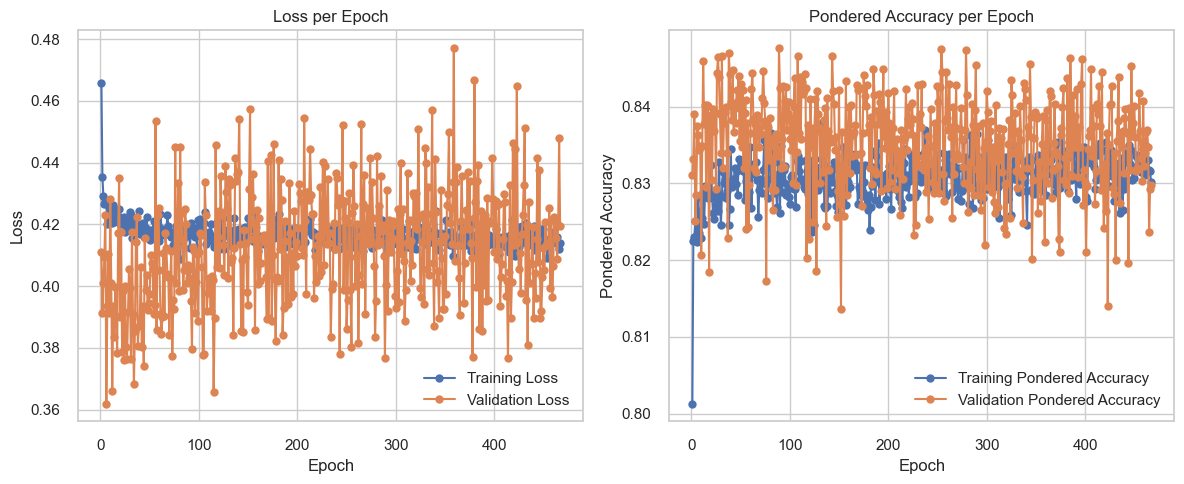

In [ ]:
# Extraer datos del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_pondered_acc = history.history['pondered_accuracy']
val_pondered_acc = history.history['val_pondered_accuracy']

# Configurar las épocas
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graficar la métrica personalizada
plt.subplot(1, 2, 2)
plt.plot(epochs, train_pondered_acc, label='Training Pondered Accuracy', marker='o')
plt.plot(epochs, val_pondered_acc, label='Validation Pondered Accuracy', marker='o')
plt.title('Pondered Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pondered Accuracy')
plt.legend()
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el modelo
loss, pondered_acc = model.evaluate(x_test_clean, y_test_clean, verbose=1)
print(f"Test Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")

177/177 [==============================] - 0s 2ms/step - loss: 0.4246 - pondered_accuracy: 0.8197
Test Loss: 0.4246, Pondered Accuracy: 0.8197


In [ ]:
# Realizar las predicciones (probabilidades)
y_pred_prob = model.predict(x_test_clean)

# Convertir a predicciones binarias usando un umbral (por defecto, 0.5)
y_pred_binary = (y_pred_prob > 0.28).astype(int)

# Mostrar las probabilidades y las predicciones
print("Predicciones (probabilidades):", y_pred_prob[:10].flatten())  # Mostrar primeras 10 probabilidades
print("Predicciones (binarias):", y_pred_binary[:10].flatten())      # Mostrar primeras 10 predicciones

177/177 [==============================] - 0s 877us/step
Predicciones (probabilidades): [5.4509467e-01 5.8295184e-01 9.9584121e-01 2.8220701e-04 7.4238069e-02
 5.4741615e-01 2.0442584e-01 6.0523480e-01 2.7259274e-03 5.8274782e-01]
Predicciones (binarias): [1 1 1 0 0 1 0 1 0 1]


In [ ]:
# Crear un DataFrame con los valores reales y predichos
results_df = pd.DataFrame({
    "Actual": y_test_clean,  # Valores reales
    "Predicted": y_pred_binary.flatten()  # Valores predichos
})

# Mostrar las primeras filas del DataFrame
print(results_df)


      Actual  Predicted
0          0          1
1          0          1
2          1          1
3          0          0
4          0          0
...      ...        ...
5642       0          0
5643       0          0
5644       0          1
5645       0          0
5646       1          1

[5647 rows x 2 columns]


In [ ]:
# Filtrar casos en los que el modelo se equivocó
errors = results_df[results_df["Actual"] != results_df["Predicted"]]
print(errors)

      Actual  Predicted
0          0          1
1          0          1
5          0          1
7          0          1
9          0          1
...      ...        ...
5637       0          1
5638       0          1
5639       0          1
5640       0          1
5644       0          1

[1957 rows x 2 columns]


In [ ]:
# Generar un informe detallado
print("Classification Report:\n", classification_report(y_test_clean, y_pred_binary))
print("Classification Report:\n", confusion_matrix(y_test_clean, y_pred_binary))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.57      0.72      4373
           1       0.39      0.94      0.55      1274

    accuracy                           0.65      5647
   macro avg       0.68      0.76      0.63      5647
weighted avg       0.84      0.65      0.68      5647

Classification Report:
 [[2488 1885]
 [  72 1202]]


In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test_clean, y_pred_binary).ravel()

print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

True Negatives (TN): 2488
False Positives (FP): 1885
False Negatives (FN): 72
True Positives (TP): 1202


Mismo modelo con F1-score

In [242]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

In [167]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir la métrica personalizada
def pondered_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.28, tf.int32)  # Umbral 0.5
    y_true = tf.cast(y_true, tf.int32)

    recall_0 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 0, y_pred_binary == 0), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 0, tf.float32)) + tf.keras.backend.epsilon())
    
    recall_1 = tf.reduce_sum(
        tf.cast(tf.logical_and(y_true == 1, y_pred_binary == 1), tf.float32)) / (
        tf.reduce_sum(tf.cast(y_true == 1, tf.float32)) + tf.keras.backend.epsilon())

    return (2 * recall_1 + recall_0) / 3

# Hiperparámetros
# num_units1 = 42 # Neuronas de la primera capa
# num_units2 = 27 # Neuronas de la segunda capa
# dropout_rate = 0.153981811279579 # Tasa de Dropout
# learning_rate = 0.013243815718680912 # Tasa de aprendizaje
# l1_reg = 0.0001284437615085618 # Regularización L1
# epochs = 88 # Número de épocas
# batch_size = 29 # Tamaño de batch

num_units1 = 17 # Neuronas de la primera capa
num_units2 = 57 # Neuronas de la segunda capa
dropout_rate = 0.3828972313881116 # Tasa de Dropout
learning_rate = 0.014453295559638146 # Tasa de aprendizaje
l1_reg = 3.136751880605585e-05 # Regularización L1
epochs = 467 # Número de épocas
batch_size = 105 # Tamaño de batch

# Construir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(num_units1, activation=LeakyReLU(alpha=0.1), input_shape=(X_train_rn.shape[1],),
                            kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_units2, activation=LeakyReLU(alpha=0.1),
                            kernel_regularizer=tf.keras.regularizers.l1(l1_reg)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Ajustar el modelo
history = model.fit(
    X_train_rn, y_train_rn,
    validation_data=(X_valid_rn, y_valid_rn),
    epochs=epochs,  # Optimizamos las épocas
    batch_size=batch_size,  # Optimizamos el tamaño del batch
    class_weight=class_weight_dict,
    verbose=0
)

# Evaluar el modelo
loss, pondered_acc = model.evaluate(X_valid_rn, y_valid_rn, verbose=1)
print(f"Validation Loss: {loss:.4f}, Pondered Accuracy: {pondered_acc:.4f}")

140/140 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.7991
Validation Loss: 0.4240, Pondered Accuracy: 0.7991


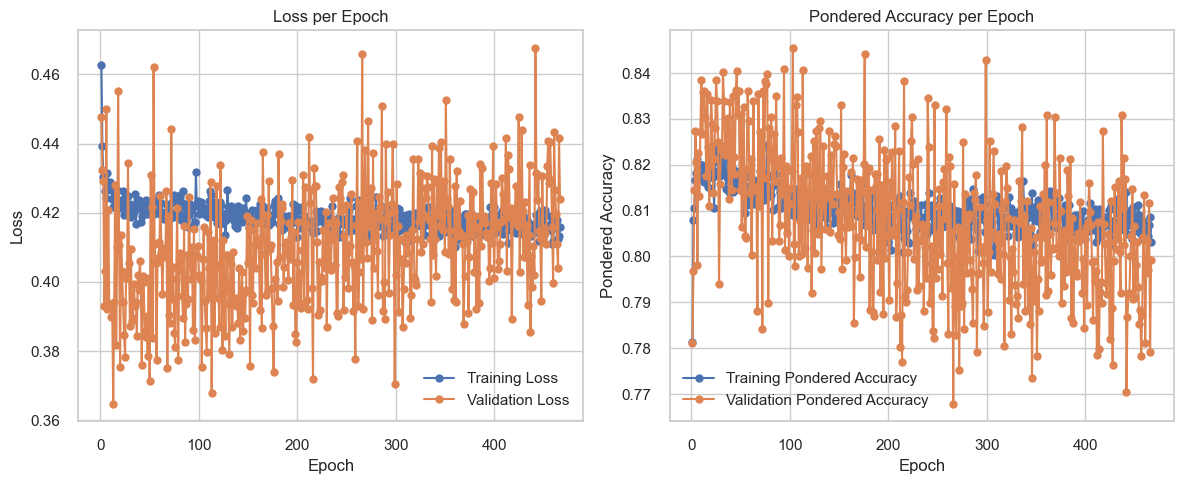

In [169]:
# Extraer datos del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_pondered_acc = history.history['accuracy']
val_pondered_acc = history.history['val_accuracy']

# Configurar las épocas
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graficar la métrica personalizada
plt.subplot(1, 2, 2)
plt.plot(epochs, train_pondered_acc, label='Training Pondered Accuracy', marker='o')
plt.plot(epochs, val_pondered_acc, label='Validation Pondered Accuracy', marker='o')
plt.title('Pondered Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pondered Accuracy')
plt.legend()
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [164]:
print(f"X_train_rn shape: {X_train_rn.shape}")
print(f"y_train_rn shape: {y_train_rn.shape}")
print(f"X_valid_rn shape: {X_valid_rn.shape}")
print(f"y_valid_rn shape: {y_valid_rn.shape}")


X_train_rn shape: (17802, 39)
y_train_rn shape: (17802,)
X_valid_rn shape: (4451, 39)
y_valid_rn shape: (4451,)


### Limpieza de codigo

In [ ]:
# Verificar si hay GPU disponible
if tf.config.list_physical_devices('GPU'):
    device = "/GPU:0"  # Usar la primera GPU disponible
else:
    device = "/CPU:0"  # Usar CPU si no hay GPU

device

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1,  l2
from sklearn.utils.class_weight import compute_class_weight

In [141]:
X_train_rn, X_valid_rn, y_train_rn, y_valid_rn = train_test_split(x_train_clean, y_train_clean, test_size=0.2, random_state=42)

#### Modelo simple con métrica Recall

In [142]:
# Calcular pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_rn), y=y_train_rn)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Crear el modelo
model = Sequential([
    Dense(4, activation=LeakyReLU(alpha=0.1), input_shape=(X_train_rn.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.1)),
    Dropout(0.1),
    Dense(2, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l1(0.1)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar el modelo con múltiples métricas
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', 'Recall', 'Precision'])  # Añadimos las métricas

# Entrenar el modelo
history = model.fit(X_train_rn, y_train_rn,
                    validation_data=(X_valid_rn, y_valid_rn),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,  # Ajustar por desbalance
                    verbose=1)

# Evaluar el modelo
loss, binary_accuracy, recall, precision = model.evaluate(X_valid_rn, y_valid_rn, verbose=0)

# Mostrar resultados
print(f"Validation Loss: {loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


KeyError: 3

In [143]:
# Extraer historial de entrenamiento
history_dict = history.history

# Graficar pérdida
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_dict['val_loss'], label='Pérdida de Validación', linestyle='--')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Graficar binary_accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['binary_accuracy'], label='Precisión Binaria de Entrenamiento')
plt.plot(history_dict['val_binary_accuracy'], label='Precisión Binaria de Validación', linestyle='--')
plt.title('Precisión Binaria durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión Binaria')
plt.legend()
plt.grid()
plt.show()

# Graficar Recall
plt.figure(figsize=(12, 6))
plt.plot(history_dict['recall'], label='Recall de Entrenamiento')
plt.plot(history_dict['val_recall'], label='Recall de Validación', linestyle='--')
plt.title('Recall durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

# Graficar Precision
plt.figure(figsize=(12, 6))
plt.plot(history_dict['precision'], label='Precisión de Entrenamiento')
plt.plot(history_dict['val_precision'], label='Precisión de Validación', linestyle='--')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


AttributeError: 'tuple' object has no attribute 'history'

In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
"""
class NeuralNetworkTensorFlow:
        #Este es un modelo simple con TensorFlow para resolver el mismo problema. 
        #En esta clase, (1) se construye el modelo.
        #(2) Se define como se fitea el modelo
        #(3) Y como se hacen las predicciones.
    
    def __init__(self, learning_rate=0.01, epochs=500):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = self.build_model()

    def build_model(self):
     
        model = Sequential([
            Dense(2, activation='sigmoid', input_shape=(39,)),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=SGD(learning_rate=self.learning_rate), loss='mse')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
    
    def fit(self, X, y):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions
"""        

#### Pipeline

# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

##### Implementación de los Transformadores Personalizados

In [ ]:
#1. Transformador MAPEO DE COORDENADAS
""" Para incluir este mapeo de coordenadas dentro de un pipeline en Scikit-learn, puedes crear un transformador personalizado que utilice el diccionario ciudades_coords para asignar las columnas de latitud y longitud basándose en la columna Location. 
Este transformador también debe eliminar la columna original Location después de realizar la transformación."""
from sklearn.base import BaseEstimator, TransformerMixin

class AddCoordinates(BaseEstimator, TransformerMixin):
    """Transformador para agregar latitud y longitud basándose en un diccionario de coordenadas."""
    
    def __init__(self, coord_dict):
        self.coord_dict = coord_dict

    def fit(self, X, y=None):
        return self  # No hay parámetros que ajustar

    def transform(self, X):
        X = X.copy()
        # Crear las nuevas columnas Latitude y Longitude
        X['Latitude'] = X['Location'].map(lambda loc: self.coord_dict[loc]['Latitud'])
        X['Longitude'] = X['Location'].map(lambda loc: self.coord_dict[loc]['Longitud'])
        # Eliminar la columna Location
        X = X.drop('Location', axis=1)
        return X

# Resultado Final:

            # Se transforma el DataFrame inicial para incluir las columnas Latitude y Longitude.
            # Se elimina la columna Location.

In [366]:
# Crear el transformador para agregar coordenadas
coord_transformer = AddCoordinates(coord_dict=ciudades_coords)

In [ ]:
#2. Transformador para eliminar filas con valores nulos en la variable objetivo

class DropMissingTarget(BaseEstimator, TransformerMixin):
    """Elimina observaciones con valores nulos en la variable target."""
    
    def __init__(self, target_column):
        self.target_column = target_column

    def fit(self, X, y=None):
        """No se necesita ajuste; simplemente devuelve self."""
        return self

    def transform(self, X):
        """Elimina filas donde la columna target tiene valores nulos."""
        X = X.copy()
        X = X.dropna(subset=[self.target_column])  # Eliminar filas con valores nulos en target_column
        return X


In [370]:
# Crear el transformador para eliminar filas con valores nulos en la variable objetivo
drop_missing_target = DropMissingTarget(target_column='RainTomorrow')

Para integrar la lógica de imputación de transformaciones personalizadas, como por ej. de direcciones de viento en un pipeline, es necesario encapsular esa función en un transformador personalizado compatible con Scikit-learn. 
Esto asegura que el pipeline pueda aplicar la imputación de manera automática.
    
#Crear un Transformador Personalizado
        Usaremos la clase BaseEstimator y TransformerMixin de Scikit-learn para definir la lógica de imputación.
        Al combinar BaseEstimator y TransformerMixin, puedes crear transformadores que: *compatibles con pipelines de Scikit-learn.
                                                                                        * Soporten métodos estándar (fit, transform, fit_transform).
                                                                                        * Sean compatibles con herramientas de ajuste como GridSearchCV.

BaseEstimator garantiza que tu transformador sea consistente con los estándares de Scikit-learn.
TransformerMixin simplifica la implementación al proporcionar el método fit_transform."""

In [ ]:
#3. TRansformador para manejar la fecha y el mes

class DateTransformer(BaseEstimator, TransformerMixin):
    """Transformador para manejar columnas relacionadas con fechas y extraer el mes como categórico."""
    
    def __init__(self, date_column='Date', month_column='Month'):
        self.date_column = date_column
        self.month_column = month_column
        self.month_dict = {
            1: 'ene', 2: 'feb', 3: 'mar', 4: 'abr',
            5: 'may', 6: 'jun', 7: 'jul', 8: 'ago',
            9: 'sep', 10: 'oct', 11: 'nov', 12: 'dic'
        }

    def fit(self, X, y=None):
        """No requiere ajuste; simplemente devuelve self."""
        return self

    def transform(self, X):
        """Convierte la columna de fecha y extrae el mes como categórico."""
        X = X.copy()
        # Convertir la columna de fechas
        X[self.date_column] = pd.to_datetime(X[self.date_column], format='mixed', errors='coerce')
        # Extraer el mes y mapearlo al nombre del mes
        X[self.month_column] = X[self.date_column].dt.month.map(self.month_dict)
        return X

In [372]:
# Crear el transformador para manejar la fecha y el mes
date_transformer = DateTransformer(date_column='Date', month_column='Month')

In [375]:
class DropRowsWithManyNulls(BaseEstimator, TransformerMixin):
    """Elimina filas con más de un cierto número de valores nulos."""
    
    def __init__(self, max_nulls):
        self.max_nulls = max_nulls

    def fit(self, X, y=None):
        """No requiere ajuste; simplemente devuelve self."""
        return self

    def transform(self, X):
        """Elimina filas con más valores nulos que el límite especificado."""
        X = X.copy()
        # Filtrar filas con al menos (total columnas - max_nulls) valores no nulos
        X = X.dropna(thresh=X.shape[1] - self.max_nulls)
        return X


In [376]:
# Crear el transformador para eliminar filas con demasiados valores nulos
drop_null_rows = DropRowsWithManyNulls(max_nulls=3)

In [ ]:
# Transformador 3: Imputación por Media Segmentada por Mes
class MediaSegmentadaPorMesImputer(BaseEstimator, TransformerMixin):
    """Imputa valores faltantes usando la media segmentada por mes."""
    
    def __init__(self, variables, mes_col='Month'):
        self.variables = variables
        self.mes_col = mes_col

    def fit(self, X, y=None):
        self.medianas_por_mes_ = {}
        for var in self.variables:
            self.medianas_por_mes_[var] = X.groupby(self.mes_col)[var].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].fillna(X[self.mes_col].map(self.medianas_por_mes_[var]))
        return X


In [ ]:
# Transformador 4 personalizado para imputar vientos
class WindDirectionImputer(BaseEstimator, TransformerMixin):
    """Transformador personalizado para imputar valores de direcciones de viento."""
    
    def __init__(self):
        pass  # No se requieren parámetros para este transformador

    def fit(self, X, y=None):
        """Este transformador no requiere ajuste previo, así que retornamos self."""
        return self  

    def transform(self, X):
        """Imputación de direcciones de viento en función de las reglas definidas."""
        X = X.copy()  # Copiar el dataframe para no modificar los datos originales
        
        # Imputar 'WindDir9am' y 'WindDir3pm' en función de 'WindGustDir'
        X['WindDir9am'] = X.apply(
            lambda row: row['WindGustDir'] if pd.isna(row['WindDir9am']) and pd.notna(row['WindGustDir']) else row['WindDir9am'],
            axis=1
        )
        X['WindDir3pm'] = X.apply(
            lambda row: row['WindGustDir'] if pd.isna(row['WindDir3pm']) and pd.notna(row['WindGustDir']) else row['WindDir3pm'],
            axis=1
        )

        # Imputación de 'WindGustDir' en función de 'WindDir9am' y 'WindDir3pm'
        X['WindGustDir'] = X.apply(
            lambda row: row['WindDir9am'] if pd.isna(row['WindGustDir']) and pd.notna(row['WindDir9am']) else row['WindGustDir'],
            axis=1
        )
        X['WindGustDir'] = X.apply(
            lambda row: row['WindDir3pm'] if pd.isna(row['WindGustDir']) and pd.notna(row['WindDir3pm']) else row['WindGustDir'],
            axis=1
        )

        return X


In [ ]:
# Transformador 5: Imputación por Moda
class ModaImputer(BaseEstimator, TransformerMixin):
    """Imputa valores faltantes usando la moda."""
    
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        self.modas_ = {}
        for var in self.variables:
            self.modas_[var] = X[var].mode()[0]
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].fillna(self.modas_[var])
        return X


In [ ]:
# Transformador 6: Reducción de Categorías de Dirección de Viento
class DireccionVientoReducer(BaseEstimator, TransformerMixin):
    """Reduce las categorías de las direcciones de viento."""
    
    def __init__(self, variables, direction_dict):
        self.variables = variables
        self.direction_dict = direction_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].map(self.direction_dict)
        return X


In [ ]:
# Transformador 7: 
"""Este transformador aplicará la regla del rango intercuartílico para detectar e imputar valores atípicos en la columna Rainfall."""
class OutlierImputer(BaseEstimator, TransformerMixin):
    """Imputa valores atípicos en una columna numérica basada en el rango intercuartílico."""
    
    def __init__(self, column):
        self.column = column
        self.valor_tipico_sup_ = None

    def fit(self, X, y=None):
        """Calcula el límite superior típico para la imputación."""
        s_columna = X[self.column][X[self.column] > 0]  # Considerar solo valores positivos
        q1, q3 = s_columna.quantile([0.25, 0.75])
        r_i = q3 - q1
        self.valor_tipico_sup_ = q3 + 1.5 * r_i  # Calcular límite superior
        return self

    def transform(self, X):
        """Imputa los valores atípicos con el límite superior calculado."""
        X = X.copy()  # Evitar modificar los datos originales
        idx_outliers = X[X[self.column] > self.valor_tipico_sup_].index
        X.loc[idx_outliers, self.column] = self.valor_tipico_sup_
        return X

In [304]:
# Definición de variables
media_segmentada_vars = ['Sunshine', 'Cloud9am', 'Cloud3pm', 'Evaporation']
moda_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
direccion_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
direction_dict = {
    'SSW':'S', 'S':'S', 'SE':'S', 'NNE':'N', 'WNW':'W', 'N':'N', 'ENE':'E',
    'NE':'N', 'E':'E', 'SW':'S', 'W':'W', 'WSW':'W', 'NNW':'N', 'ESE':'E', 'SSE':'S', 'NW':'N'
}

# Crear los transformadores personalizados
media_segmentada_imputer = MediaSegmentadaPorMesImputer(variables=media_segmentada_vars, mes_col='Month')
moda_imputer = ModaImputer(variables=moda_vars)
direccion_reducer = DireccionVientoReducer(variables=direccion_vars, direction_dict=direction_dict)
wind_direction_imputer= WindDirectionImputer()


In [ ]:
# Crear el transformador para imputar valores atípicos en 'Rainfall'
outlier_imputer = OutlierImputer(column='Rainfall')

In [379]:
# Transformador 5 de Variables categoricas
#from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class AutoCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Transformador para identificar y codificar columnas categóricas automáticamente."""
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """No requiere ajuste, simplemente devuelve self."""
        return self

    def transform(self, X):
        """Identifica columnas cualitativas y aplica codificación One-Hot a ellas."""
        X = X.copy()  # Evitar modificar el DataFrame original
        
        # Identificar columnas cualitativas (categóricas)
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        
        # Si no hay columnas cualitativas, devolver X sin cambios
        if categorical_cols.empty:
            return X
        
        # Aplicar OneHotEncoder solo a las columnas cualitativas
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        one_hot_encoded = encoder.fit_transform(X[categorical_cols])
        
        # Crear un DataFrame con las columnas codificadas
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)
        
        # Concatenar las columnas originales con las codificadas
        X = pd.concat([X, one_hot_df], axis=1)
        
        # Eliminar las columnas originales cualitativas
        X = X.drop(categorical_cols, axis=1)
        
        return X



In [301]:
# Imputaciones/Transformaciones en dataframe entero
""" La clase WindDirectionImputer funciona con un DataFrame completo, no con columnas específicas, lo que hace que no sea directamente compatible con ColumnTransformer."""

dataset_transform = ([
    ('reducir_direccion_viento', direccion_reducer),
    ('Imputar', wind_direction_imputer, ['WindGustDir', 'WindDir9am', 'WindDir3pm'] ) # Imputar direcciones de viento
])

In [374]:
#Imputaciones 
imputer_median = SimpleImputer( strategy= "median")
imputer_mean = SimpleImputer( strategy = "mean")


In [ ]:
# Transformaciones en columnas 
from sklearn.compose import ColumnTransformer
preprocessor= ColumnTransformer([
        ('add_coordinates', coord_transformer),  # Agregar columnas Latitude y Longitude)
        ('drop_missing_target', drop_missing_target),  # Eliminar observaciones con RainTomorrow nulo
        ('date_transformer', date_transformer),  # Transformar fecha y mes
        ('drop_null_rows', drop_null_rows),  # Filtrar filas con más de 3 valores nulos
        ('auto_categorical_encoder', AutoCategoricalEncoder()), # Codificar columnas cualitativas automáticamente
        ('Imputer_median', imputer_median,['WindGustSpeed','Humidity9am', 'Humidity3pm','Rainfall','WindSpeed9am','WindSpeed3pm','Pressure9am','Pressure3pm']),
        ('Imputer_mean', imputer_mean,['MinTemp','MaxTemp', 'Temp9am','Temp3pm']),
        ('imputar_moda', moda_imputer),
        ('imputar_media_segmentada', media_segmentada_imputer),
        ('outlier_imputer', outlier_imputer),
])


Para integrar el proceso de escalado en tu pipeline, debemos asegurarnos de que solo se apliquen transformaciones como el escalado a las variables cuantitativas y que las variables cualitativas no sean afectadas. Esto se puede lograr con un ColumnTransformer, donde se aplican transformaciones específicas a subconjuntos de columnas.
Pasos para Detallar el Escalado de Datos
1.Separar las columnas cuantitativas y cualitativas:
2.Las cuanti (features_cuanti) se escalan.
3.Las cuali (features_cuali) permanecen sin escalar.
Usar ColumnTransformer para definir las transformaciones por tipo de variable:

Escalar las variables cuantitativas con StandardScaler.
Pasar las variables cualitativas sin transformaciones utilizando 'passthrough'.
Reintegrar los datos procesados:

Después de aplicar el ColumnTransformer, los datos transformados combinan tanto las variables escaladas como las cualitativas sin escalado.

In [ ]:
# Crear el ColumnTransformer para separar las transformaciones
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_cuanti),  # Escalado de las cuantitativas
        ('passthrough', 'passthrough', features_cuali)  # Pasar cualitativas sin cambios
    ]
)



In [281]:
class KerasClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, model=None):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# 4. Construir el pipeline
keras_model = KerasClassifier(model=model)

##### PIPELINE FINAL

In [ ]:
# Pipeline final
pipeline = Pipeline(steps=[
    ('fill_na',preprocessor),
    ('df_transform', dataset_transform),
    ('scale', scaler),
    ('moodel', keras_model)
])


In [ ]:
# TODAVIA NO LO VI
# # Dividir los datos en conjuntos de entrenamiento y prueba
X_train_pipe = x_train_clean.copy()  # Asegúrate de usar tus datos procesados
y_train_pipe = y_train_clean.copy()

# Entrenar el pipeline
pipeline.fit(X_train_pipe, y_train_pipe)

# Transformar los datos
X_train_transformed = pipeline.transform(X_train)


In [ ]:
# TODAVIA NO LO VI
# Evaluar el modelo
y_pred = pipeline.predict(X_test)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Guardar el pipeline para Docker
import joblib
joblib.dump(pipeline, 'pipeline_model.pkl')

In [ ]:
"""" Ejemplo  NO MIRAR, ES DE EJEMPLO
# 1. Cargar y preprocesar tus datos
# Asegúrate de que tus datos estén en las variables X_train, y_train, X_test, y_test
# Ejemplo con datos ficticios:

# Escalar los datos de entrada
scaler = StandardScaler()

# 2. Crear el modelo de red neuronal (en este caso, ya entrenado)
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X.shape[1]),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Para clasificación binaria
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Crear un adaptador para el modelo Keras que sea compatible con el pipeline de Scikit-learn
class KerasClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, model=None):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# 4. Construir el pipeline
model = create_model()
keras_model = KerasClassifier(model=model)

# 5. Crear el pipeline final
pipeline = Pipeline([
    ('scaler', scaler),  # Preprocesamiento: escalado de características
    ('model', keras_model)  # Modelo de red neuronal
])

# 6. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Entrenar el modelo con el pipeline
pipeline.fit(X_train, y_train)

# 8. Evaluar el modelo
score = pipeline.score(X_test, y_test)
print(f"Accuracy en el conjunto de test: {score:.4f}")
"""

#### Docker

Armar carpeta Docker en el directorio de trabajo actual. Si la carpeta no existe, obtendrás un error. Puedes crearla manualmente o verificar que exista antes de guardar el archivo.

In [ ]:
# creo carpeta Docker
import os
if not os.path.exists('Docker'):
    os.makedirs('Docker')


Formato HDF5: El archivo .h5 almacena tanto la arquitectura como los pesos del modelo. También puedes guardar el optimizador y otros detalles si lo deseas, y posteriormente cargar el modelo con tensorflow.keras.models.load_model().

Guardar el modelo completo: La función save() guarda todo el modelo, incluyendo:

Arquitectura del modelo.
Pesos entrenados.
Configuración del optimizador.
Estado del entrenamiento (como el número de épocas completadas si se utiliza para continuar el entrenamiento).

Cargar el modelo guardado:
Una vez que hayas guardado el modelo, puedes cargarlo nuevamente para usarlo o continuar entrenando con:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("Docker/rnn.h5")
